# divide observations into watermasses based on location
## in this file our cuttoff of latitudes follows the definitions of the nothern CCS in Checkley & Barth 2009

In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from scipy.interpolate import interpn
import cmocean as cm
import gsw
import datetime as dt
from scipy.stats import pearsonr

from cartopy import crs, feature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# for ellipse
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from scipy.stats import chi2, mode
from scipy.spatial.distance import mahalanobis

# for anova
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from itertools import combinations

import warnings
warnings.filterwarnings("ignore")

In [3]:
grid = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/LiveOcean/grid.nc')
obs = pd.read_csv('./filtered_obs.csv')

In [4]:
obs = obs[(obs['latitude (degrees_north)']>=40) & (obs['latitude (degrees_north)']<=50.8)].reset_index() # decreases from 1006797 to 883969
obs.drop(columns=['index','Unnamed: 0.1','Unnamed: 0'],inplace=True)


In [5]:
set(obs.source)

{'GEOTRACES',
 'NCEI Coastal',
 'NCEI Coastal, NHL',
 'NCEI PNW',
 'NCEI Salish',
 'NHL',
 'OCNMS',
 'ios bottle',
 'ios bottle, GEOTRACES',
 'ios bottle, NCEI PNW',
 'ios bottle, NCEI PNW, GEOTRACES',
 'ios ctd profiles',
 'ios ctd profiles, ios bottle',
 'ios mooring',
 'ios mooring, ios bottle',
 'ooi'}

In [11]:
# check what years we have geotraces for (for paper)
np.max(obs.time[(obs.source=='GEOTRACES')|(obs.source=='ios bottle, GEOTRACES')|(obs.source=='ios bottle, GEOTRACES')])

Timestamp('2020-08-24 00:00:00+0000', tz='UTC')

In [6]:
# can't believe you haven't made a density column yet 
CT = gsw.CT_from_t(obs['salinity (g kg-1)'],obs['temperature (degC)'],obs['pressure (dbar)'])
rho = gsw.rho_alpha_beta(np.array(obs['salinity (g kg-1)']), CT, np.array(obs['pressure (dbar)']))[0]
obs['density (kg m-3)'] = rho

In [7]:
# can we be smarter about date division
# transition dates based on Bakun index analysis  
fall = pd.to_datetime(['1967-09-28T00:00:00.000000000', '1968-10-08T00:00:00.000000000',
       '1969-09-15T00:00:00.000000000', '1970-10-13T00:00:00.000000000',
       '1971-10-17T00:00:00.000000000', '1972-10-29T00:00:00.000000000',
       '1973-10-14T00:00:00.000000000', '1974-11-02T00:00:00.000000000',
       '1975-09-29T00:00:00.000000000', '1976-10-22T00:00:00.000000000',
       '1977-10-19T00:00:00.000000000', '1978-11-13T00:00:00.000000000',
       '1979-10-16T00:00:00.000000000', '1980-10-21T00:00:00.000000000',
       '1981-09-19T00:00:00.000000000', '1982-10-04T00:00:00.000000000',
       '1983-10-17T00:00:00.000000000', '1984-10-02T00:00:00.000000000',
       '1985-10-17T00:00:00.000000000', '1986-10-20T00:00:00.000000000',
       '1987-11-06T00:00:00.000000000', '1988-10-26T00:00:00.000000000',
       '1989-10-15T00:00:00.000000000', '1990-10-16T00:00:00.000000000',
       '1991-10-31T00:00:00.000000000', '1992-10-15T00:00:00.000000000',
       '1993-11-22T00:00:00.000000000', '1994-10-21T00:00:00.000000000',
       '1995-11-05T00:00:00.000000000', '1996-10-01T00:00:00.000000000',
       '1997-09-24T00:00:00.000000000', '1998-10-09T00:00:00.000000000',
       '1999-10-21T00:00:00.000000000', '2000-10-14T00:00:00.000000000',
       '2001-10-24T00:00:00.000000000', '2002-11-03T00:00:00.000000000',
       '2003-10-04T00:00:00.000000000', '2004-10-30T00:00:00.000000000',
       '2005-09-30T00:00:00.000000000', '2006-10-31T00:00:00.000000000',
       '2007-09-28T00:00:00.000000000', '2008-09-22T00:00:00.000000000',
       '2009-10-11T00:00:00.000000000', '2010-09-22T00:00:00.000000000',
       '2011-09-16T00:00:00.000000000', '2012-10-11T00:00:00.000000000',
       '2013-11-03T00:00:00.000000000', '2014-09-22T00:00:00.000000000',
       '2015-10-06T00:00:00.000000000', '2016-10-02T00:00:00.000000000',
       '2017-10-15T00:00:00.000000000', '2018-10-22T00:00:00.000000000',
       '2019-11-06T00:00:00.000000000', '2020-11-11T00:00:00.000000000',
       '2021-09-15T00:00:00.000000000', '2022-10-24T00:00:00.000000000',
       '2023-09-22T00:00:00.000000000'], utc=True)
spring =pd.to_datetime(['1967-03-27T00:00:00.000000000', '1968-03-26T00:00:00.000000000',
       '1969-04-26T00:00:00.000000000', '1970-03-15T00:00:00.000000000',
       '1971-04-13T00:00:00.000000000', '1972-03-21T00:00:00.000000000',
       '1973-03-19T00:00:00.000000000', '1974-04-08T00:00:00.000000000',
       '1975-03-21T00:00:00.000000000', '1976-04-09T00:00:00.000000000',
       '1977-03-11T00:00:00.000000000', '1978-03-07T00:00:00.000000000',
       '1979-03-14T00:00:00.000000000', '1980-03-01T00:00:00.000000000',
       '1981-03-24T00:00:00.000000000', '1982-03-03T00:00:00.000000000',
       '1983-04-01T00:00:00.000000000', '1984-04-18T00:00:00.000000000',
       '1985-02-14T00:00:00.000000000', '1986-03-26T00:00:00.000000000',
       '1987-03-12T00:00:00.000000000', '1988-04-05T00:00:00.000000000',
       '1989-04-04T00:00:00.000000000', '1990-03-25T00:00:00.000000000',
       '1991-04-08T00:00:00.000000000', '1992-03-04T00:00:00.000000000',
       '1993-04-26T00:00:00.000000000', '1994-03-23T00:00:00.000000000',
       '1995-03-22T00:00:00.000000000', '1996-04-25T00:00:00.000000000',
       '1997-03-30T00:00:00.000000000', '1998-02-21T00:00:00.000000000',
       '1999-03-29T00:00:00.000000000', '2000-03-18T00:00:00.000000000',
       '2001-02-21T00:00:00.000000000', '2002-03-22T00:00:00.000000000',
       '2003-04-11T00:00:00.000000000', '2004-03-29T00:00:00.000000000',
       '2005-05-22T00:00:00.000000000', '2006-04-18T00:00:00.000000000',
       '2007-03-11T00:00:00.000000000', '2008-03-27T00:00:00.000000000',
       '2009-03-03T00:00:00.000000000', '2010-04-04T00:00:00.000000000',
       '2011-03-29T00:00:00.000000000', '2012-04-19T00:00:00.000000000',
       '2013-03-19T00:00:00.000000000', '2014-03-20T00:00:00.000000000',
       '2015-02-12T00:00:00.000000000', '2016-03-23T00:00:00.000000000',
       '2017-04-22T00:00:00.000000000', '2018-02-01T00:00:00.000000000',
       '2019-04-06T00:00:00.000000000', '2020-01-31T00:00:00.000000000',
       '2021-03-19T00:00:00.000000000', '2022-04-20T00:00:00.000000000',
       '2023-04-22T00:00:00.000000000'], utc=True)

In [8]:
# first lets work with the data covered by the Bakun index
obs['time'] = pd.to_datetime(obs.time)
obs['season'] = 'none'
for i in range(len(spring)):
    obs.season[(obs.time-spring[i]>=dt.timedelta(days=0)) & (obs.time-fall[i]<dt.timedelta(days=0))] = 'up'
for i in range(len(spring)-1):
    obs.season[(obs.time-spring[i+1]<dt.timedelta(days=0)) & (obs.time-fall[i]>=dt.timedelta(days=0))] = 'down'


# then for the data before then choose a conservative split
obs.season[(obs.time-spring[0]<dt.timedelta(days=0)) & ((obs.month >=11) | (obs.month <=2))] = 'down'
obs.season[(obs.time-spring[0]<dt.timedelta(days=0)) & (obs.month >= 5) & (obs.month <=8)] = 'up'

In [23]:
# we're going to divide our watermasses differently during upwelling and downwelling
# so split into summer and winter datasets before we do this
# in the future i would like to split this data up based on the actual timing of upwelling and downwelling, but for now lets just do this simple separation 

# wob = obs[(obs.month >=11) | (obs.month <=2)]
# sob = obs[(obs.month >= 5) & (obs.month <=8)]
wob = obs[obs.season == 'down']
sob = obs[obs.season == 'up']

## Functions

In [24]:
########################
# TS DIAGRAM FUNCTIONS #
########################

# I want to add lines of constant spice
smin, smax = 28.2,36.6
tmin, tmax = 1,19.6
bins = [np.linspace(smin, smax,100),np.linspace(tmin, tmax,100)]
SA, t = np.meshgrid(bins[0],bins[1])
p = np.array([50 for i in range(np.shape(SA)[0]*np.shape(SA)[1])])
p = p.reshape(100,100)

CT = np.zeros(np.shape(p))
rho = np.zeros(np.shape(p))
spice = np.zeros(np.shape(p))

for i in range(np.shape(p)[0]): 
    CT[i,:] = gsw.CT_from_t(SA[i,:],t[i,:],p[i,:])
    rho[i,:] = gsw.rho_alpha_beta(SA[i,:], CT[i,:], p[i,:])[0]
    spice[i,:] = gsw.spiciness0(SA[i,:], CT[i,:])

def fmt(x):
    x-=1000
    s = f"{x:.0f}"
    return rf"{s}"

def TS(df,region,ax, x, y):
    smin, smax = 28.2,36.6
    tmin = np.nanmean(df[y]) - 4*np.nanstd(df[y])
    tmax = np.nanmean(df[y]) + 4*np.nanstd(df[y])

    salt = df[x][df.region == region].reset_index(drop=True)
    temp = df[y][df.region == region].reset_index(drop=True)

    bin = [np.linspace(smin,smax,100),np.linspace(tmin,tmax,100)]
    data, x_e, y_e = np.histogram2d(salt,temp, bins = bin, density = True )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ), data ,np.vstack([salt,temp]).T ,method = "splinef2d", bounds_error = False)
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    salt, temp, z = salt[idx], temp[idx], z[idx]    
    ax.scatter(salt,temp, c=z, cmap=cm.cm.dense,s=1)

    title = region + "\n n= " + str(len(temp[~np.isnan(temp)]))
    ax.set_title(title)
    ax.set_ylabel(y)
    ax.set_xlabel(x)

    ax.set_ylim([tmin,tmax])
    ax.set_xlim([smin,smax])

    if y == 'temperature (degC)' and x == 'salinity (g kg-1)':
        # density
        CS=ax.contour(SA,t,rho,colors = 'gray', alpha=0.5)
        ax.clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=10)

def TS_depth(df,region,ax):
    smin, smax = 28.2,36.6
    tmin, tmax = 1,19.6

    salt = df['salinity (g kg-1)'][df.region == region].reset_index(drop=True)
    temp = df['temperature (degC)'][df.region == region].reset_index(drop=True)
    z = df['depth (m)'][df.region == region].reset_index(drop=True)

    # Sort the points by depth, so that the deepest points are plotted last
    idx = z.argsort()
    salt, temp, z = salt[idx], temp[idx], z[idx]
                    
    sc = ax.scatter(salt,temp, c=z, cmap=cm.cm.deep,s=1,vmin=0,vmax=500)
    cb = fig.colorbar(sc, ax=ax)
    cb.set_label('Depth [m]', labelpad=10, fontsize=14)
    
    ax.set_title(region)
    ax.set_ylabel('Temperature')
    ax.set_xlabel('Salinity')

    ax.set_ylim([tmin,tmax])
    ax.set_xlim([smin,smax])

    # density
    CS=ax.contour(SA,t,rho,colors = 'gray', alpha=0.5)
    ax.clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=10)

def xy_depth(df,region,ax):

    ax.set_extent(xlim + ylim)
    ax.add_feature(feature.GSHHSFeature('auto', facecolor='whitesmoke', zorder=2))
    ax.add_feature(feature.GSHHSFeature('auto', edgecolor='k', zorder=4))

    ax.add_feature(feature.NaturalEarthFeature(name='bathymetry_K_200', scale='10m', category='physical',facecolor='white', edgecolor='k',zorder=4))
    ax.add_feature(feature.NaturalEarthFeature(name='bathymetry_J_1000', scale='10m', category='physical',facecolor='white', edgecolor='k',zorder=4))

    lon = df['longitude (degrees_east)'][(df.region == region)].reset_index(drop=True)
    lat = df['latitude (degrees_north)'][(df.region == region)].reset_index(drop=True)
    z = df['depth (m)'][(df.region == region)].reset_index(drop=True)
    idx = z.argsort()
    lon, lat, z = lon[idx], lat[idx], z[idx]

    ax.scatter(lon, lat, s=5,c=z,cmap=cm.cm.deep, transform=crs.PlateCarree(),zorder=7)
    ax.set_title(region)

In [25]:
############
# ELLIPSES #
############

def confidence_ellipse(x, y, ax, n_std=1, **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.
    """
    # Remove NaN values
    valid = ~np.isnan(x) & ~np.isnan(y)
    x_valid = x[valid]
    y_valid = y[valid]

    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x_valid, y_valid)
    pearson = cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
                      width=ell_radius_x * 2,
                      height=ell_radius_y * 2,
                      facecolor='none', **kwargs)

    scale_x = np.sqrt(cov[0, 0]) * n_std
    scale_y = np.sqrt(cov[1, 1]) * n_std
    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(np.mean(x_valid), np.mean(y_valid))

    ellipse.set_transform(transf + ax.transData)
    ax.add_patch(ellipse)

def percentile_ellipse(x, y, ax, percentile=90, **kwargs):
    """
    Create a plot of an ellipse that covers a certain percentage of the data points,
    where the rotation and center are calculated based on the subset of data within the desired percentile.
    """
    # Remove NaN values
    valid = ~np.isnan(x) & ~np.isnan(y)
    x_valid = x[valid]
    y_valid = y[valid]

    # Stack x and y together for easier distance calculations
    data = np.column_stack([x_valid, y_valid])

    # Calculate the mean and covariance matrix of the full data
    mean = np.mean(data, axis=0)
    cov = np.cov(data, rowvar=False)
    inv_covmat = np.linalg.inv(cov)

    # Calculate the Mahalanobis distance for each point
    distances = np.array([mahalanobis(point, mean, inv_covmat) for point in data])

    # Get the distance cutoff for the given percentile
    cutoff_distance = np.percentile(distances, percentile)

    # Select the subset of points within the desired percentile
    subset_mask = distances <= cutoff_distance
    subset_data = data[subset_mask]

    # Calculate the mean and covariance for the subset of data
    subset_mean = np.mean(subset_data, axis=0)
    subset_cov = np.cov(subset_data, rowvar=False)

    # Eigenvalues and eigenvectors for scaling the ellipse
    eigvals, eigvecs = np.linalg.eigh(subset_cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]

    # The lengths of the ellipse axes
    width, height = 2 * np.sqrt(eigvals * chi2.ppf(0.9, df=2))  # Adjust the scaling factor here

    # Angle of the ellipse in degrees
    angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))

    # Create the ellipse
    ellipse = Ellipse((subset_mean[0], subset_mean[1]),
                      width=width, height=height,
                      angle=angle, **kwargs)

    # Add the ellipse to the plot
    # ax.add_patch(ellipse)
    # return subset_mean[0], subset_mean[1], width, height, angle
    return ellipse

def percentile_mode_ellipse(x, y, ax, percentile=90, **kwargs):
    """
    Create a plot of an ellipse that covers a certain percentage of the data points,
    where the rotation and center are calculated based on the subset of data within the desired percentile.
    this one is centered around the mode of the data instead of the mean
    """
    # Remove NaN values
    valid = ~np.isnan(x) & ~np.isnan(y)
    x_valid = x[valid]
    y_valid = y[valid]

    # Stack x and y together for easier distance calculations
    data = np.column_stack([x_valid, y_valid])

    # Calculate the mean and covariance matrix of the full data
    mean = np.mean(data, axis=0)
    dmode = mode(data, axis=0)[0]
    cov = np.cov(data, rowvar=False)
    inv_covmat = np.linalg.inv(cov)

    # Calculate the Mahalanobis distance for each point
    distances = np.array([mahalanobis(point, dmode, inv_covmat) for point in data])

    # Get the distance cutoff for the given percentile
    cutoff_distance = np.percentile(distances, percentile)

    # Select the subset of points within the desired percentile
    subset_mask = distances <= cutoff_distance
    subset_data = data[subset_mask]

    # Calculate the mean and covariance for the subset of data
    subset_mean = np.mean(subset_data, axis=0)
    subset_cov = np.cov(subset_data, rowvar=False)

    # Eigenvalues and eigenvectors for scaling the ellipse
    eigvals, eigvecs = np.linalg.eigh(subset_cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]

    # The lengths of the ellipse axes
    width, height = 2 * np.sqrt(eigvals * chi2.ppf(0.9, df=2))  # Adjust the scaling factor here

    # Angle of the ellipse in degrees
    angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))

    # Create the ellipse
    ellipse = Ellipse((subset_mean[0], subset_mean[1]),
                      width=width, height=height,
                      angle=angle, **kwargs)

    # Add the ellipse to the plot
    ax.add_patch(ellipse)
    

In [26]:
######################
# BOX PLOT FUNCTIONS #
######################

def box(df,regions,property,ax,**kwargs):
    tracer = [df[property][df.region==region] for region in regions]

    # Filter data using np.isnan (boxplots can't really handle nans)
    t_filter = [tracer[i][~np.isnan(tracer[i])] for i in range(len(tracer))]

    bplot = ax.boxplot(t_filter, showfliers=False, patch_artist=True)
    ticks = [str(len(t_filter[i])) for i in range(len(regions))]
    ax.set_xticklabels(ticks,rotation=30,ha='right',fontsize=9)
    ax.set_ylabel(property)

    return bplot

In [27]:
obs['region'] = 'none'
obs.region[(obs.location == 'offshore') & (obs['depth (m)']>=120)] = 'offshore deep'
obs.region[(obs.location == 'offshore') & (obs['depth (m)']<120)] = 'offshore surface'
obs.region[(obs.location == 'shelf') & (obs['latitude (degrees_north)'] >= 49)] = 'north'
obs.region[(obs.location == 'shelf') & (obs['latitude (degrees_north)'] <= 47.3)] = 'south'
obs.region[(obs.location == 'slope') & (obs['latitude (degrees_north)'] >= 49) & (obs['depth (m)'] <= 200)] = 'north'
obs.region[(obs.location == 'slope') & (obs['latitude (degrees_north)'] <= 47.3) & (obs['salinity (g kg-1)'] < 33.7)] = 'south'
obs.region[(obs.location == 'slope') & (obs['latitude (degrees_north)'] <= 50.5) & (obs['salinity (g kg-1)'] >= 33.7)] = 'cuc'
obs.region[obs['salinity (g kg-1)'] <= 31.5] = 'brackish' # putting this one last will remove the <32 points from the other regions

In [28]:
# which tracers come from which sources
properties = ['temperature (degC)', 'salinity (g kg-1)', 'DO (umol kg-1)', 'NO3 (uM)',
       'NO2 (uM)', 'NH4 (uM)', 'PO4 (uM)', 'SiO4 (uM)',
       'TA (uM)', 'DIC (uM)', 'Carbonate', 'Aragonite', 'Calcite',
       'Cd (nmol kg-1)', 'Co (nmol kg-1)', 'Cu (nmol kg-1)', 'Fe (nmol kg-1)',
       'Mn (nmol kg-1)', 'Ni (nmol kg-1)', 'Zn (nmol kg-1)']

 
for prop in properties:
    print(prop)
    print(list(set(obs.source[~np.isnan(obs[prop])])))
    print("\n")

temperature (degC)
['ios bottle, GEOTRACES', 'OCNMS', 'NCEI Salish', 'ios bottle, NCEI PNW', 'ios bottle', 'NCEI Coastal, NHL', 'NCEI Coastal', 'NCEI PNW', 'ios mooring, ios bottle', 'ios ctd profiles, ios bottle', 'ios mooring', 'NHL', 'ios ctd profiles', 'ios bottle, NCEI PNW, GEOTRACES', 'ooi']


salinity (g kg-1)
['ios bottle, GEOTRACES', 'OCNMS', 'NCEI Salish', 'ios bottle, NCEI PNW', 'ios ctd profiles, ios bottle', 'ios bottle', 'NCEI Coastal', 'NCEI PNW', 'NCEI Coastal, NHL', 'ios mooring, ios bottle', 'ios mooring', 'NHL', 'ios ctd profiles', 'ios bottle, NCEI PNW, GEOTRACES', 'ooi']


DO (umol kg-1)
['ios bottle, GEOTRACES', 'OCNMS', 'NCEI Salish', 'ios bottle, NCEI PNW', 'ios bottle', 'NCEI Coastal, NHL', 'NCEI Coastal', 'NCEI PNW', 'ios mooring, ios bottle', 'ios ctd profiles, ios bottle', 'ios mooring', 'NHL', 'ios ctd profiles', 'ios bottle, NCEI PNW, GEOTRACES', 'ooi']


NO3 (uM)
['ios bottle, GEOTRACES', 'NCEI Salish', 'ios bottle, NCEI PNW', 'ios ctd profiles, ios bottl

## Summer

In [29]:
# SUMMER DIVISIONS

# all water masses are important in the summer (according to Lagrangian analysis) which complicates separation a bit

# CUC = slope water south of 50.5 & salinity greater than or equal to 33.8 (need to do sensitivity analysis on this salinity choice)
# north shelf = shelf water north of 49, slope water north of 49 in the top 200 m 
# south shelf = shelf water south of 47.3, slope was south of 47.3 with salinity less than 33.8
# brackish = salinity less than or equal to 32
# offshore = offshore of 2000 m contour

sob['region'] = 'none'
sob.region[(sob.location == 'offshore') & (sob['depth (m)']>=120)] = 'offshore deep'
sob.region[(sob.location == 'offshore') & (sob['depth (m)']<120)] = 'offshore surface'
sob.region[(sob.location == 'shelf') & (sob['latitude (degrees_north)'] >= 49)] = 'north'
sob.region[(sob.location == 'shelf') & (sob['latitude (degrees_north)'] <= 47.3)] = 'south'
sob.region[(sob.location == 'slope') & (sob['latitude (degrees_north)'] >= 49) & (sob['depth (m)'] <= 200)] = 'north'
sob.region[(sob.location == 'slope') & (sob['latitude (degrees_north)'] <= 47.3) & (sob['salinity (g kg-1)'] < 33.7)] = 'south'
sob.region[(sob.location == 'slope') & (sob['latitude (degrees_north)'] <= 50.5) & (sob['salinity (g kg-1)'] >= 33.7)] = 'cuc'
sob.region[sob['salinity (g kg-1)'] <= 31.5] = 'brackish' # putting this one last will remove the <32 points from the other regions

In [30]:
# count the number of observations for each variable
properties = ['temperature (degC)', 'salinity (g kg-1)', 'DO (umol kg-1)', 'NO3 (uM)',
       'NO2 (uM)', 'NH4 (uM)', 'PO4 (uM)', 'SiO4 (uM)',
       'TA (uM)', 'DIC (uM)', 'Carbonate', 'Aragonite', 'Calcite',
       'Cd (nmol kg-1)', 'Co (nmol kg-1)', 'Cu (nmol kg-1)', 'Fe (nmol kg-1)',
       'Mn (nmol kg-1)', 'Ni (nmol kg-1)', 'Zn (nmol kg-1)']
regions = ['offshore deep','offshore surface', 'cuc', 'north', 'south']

for reg in regions:
    print(reg)
    for prop in properties:
        print("{}= {}".format(prop,len(sob[(sob.region == reg) & ~np.isnan(sob[prop])])))
        # print(list(set(sob.source[(sob.region == reg) & ~np.isnan(sob[prop])])))
    print("\n")

offshore deep
temperature (degC)= 91293
salinity (g kg-1)= 112754
DO (umol kg-1)= 79491
NO3 (uM)= 4447
NO2 (uM)= 193
NH4 (uM)= 92
PO4 (uM)= 4796
SiO4 (uM)= 4769
TA (uM)= 176
DIC (uM)= 173
Carbonate= 38
Aragonite= 163
Calcite= 163
Cd (nmol kg-1)= 152
Co (nmol kg-1)= 152
Cu (nmol kg-1)= 152
Fe (nmol kg-1)= 152
Mn (nmol kg-1)= 152
Ni (nmol kg-1)= 152
Zn (nmol kg-1)= 151


offshore surface
temperature (degC)= 43821
salinity (g kg-1)= 69658
DO (umol kg-1)= 38122
NO3 (uM)= 8802
NO2 (uM)= 304
NH4 (uM)= 144
PO4 (uM)= 8903
SiO4 (uM)= 8390
TA (uM)= 297
DIC (uM)= 280
Carbonate= 54
Aragonite= 268
Calcite= 268
Cd (nmol kg-1)= 219
Co (nmol kg-1)= 219
Cu (nmol kg-1)= 219
Fe (nmol kg-1)= 219
Mn (nmol kg-1)= 219
Ni (nmol kg-1)= 219
Zn (nmol kg-1)= 218


cuc
temperature (degC)= 88373
salinity (g kg-1)= 101448
DO (umol kg-1)= 74869
NO3 (uM)= 6065
NO2 (uM)= 908
NH4 (uM)= 775
PO4 (uM)= 6121
SiO4 (uM)= 5979
TA (uM)= 1010
DIC (uM)= 1013
Carbonate= 274
Aragonite= 835
Calcite= 835
Cd (nmol kg-1)= 3
Co (nmol kg

Possible issue encountered when converting Shape #95 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included but were encoded as GeoJSON exterior rings instead of holes.
Possible issue encountered when converting Shape #95 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included but were encoded as GeoJSON exterior rings instead of holes.
Possible issue encountered when converting Shape #471 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included b

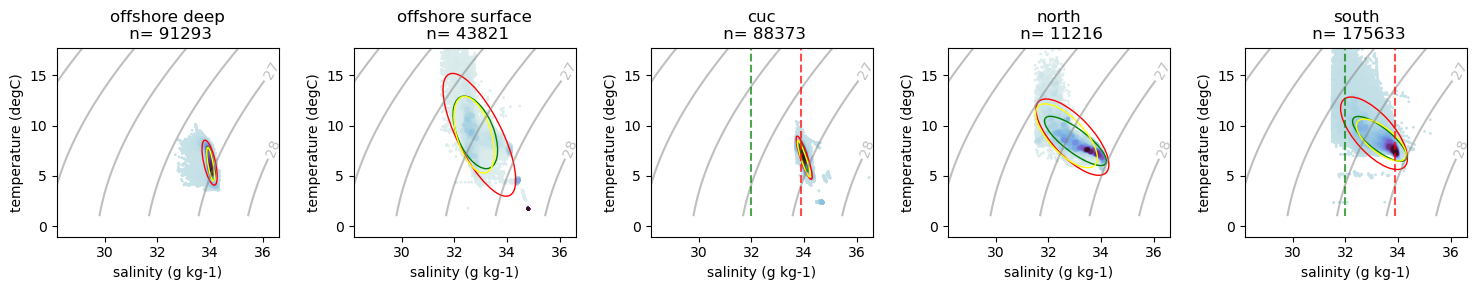

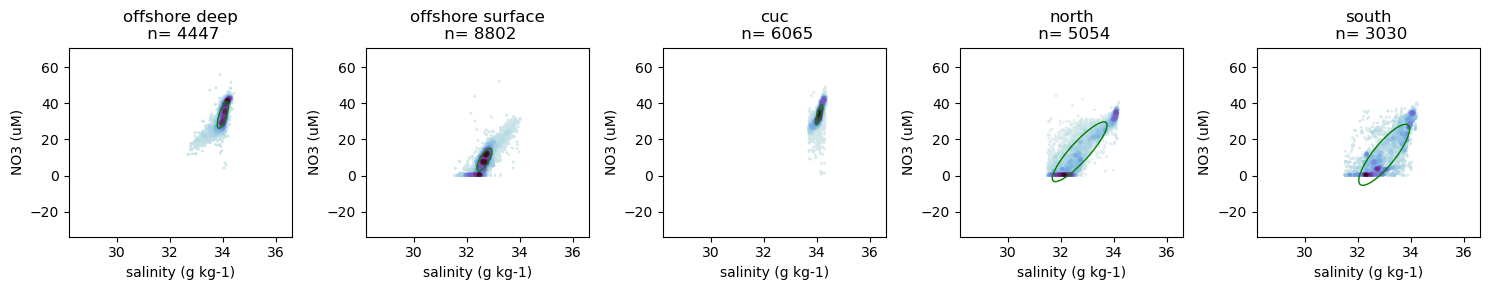

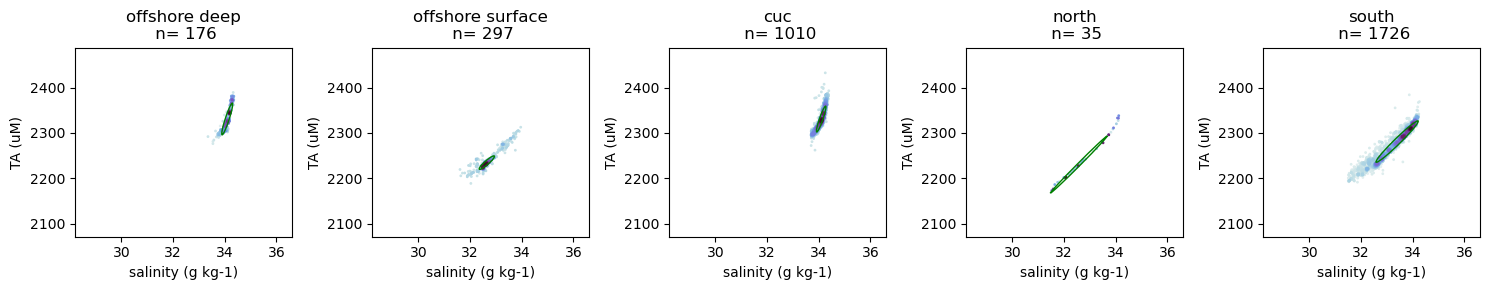

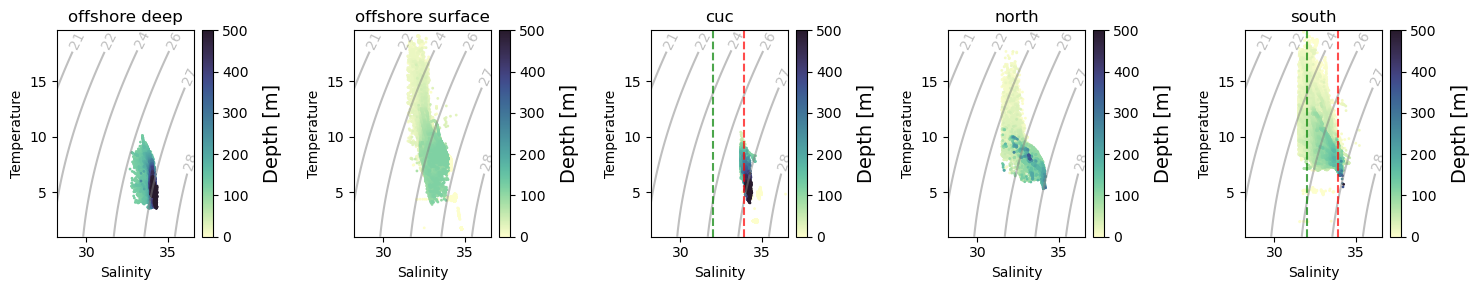

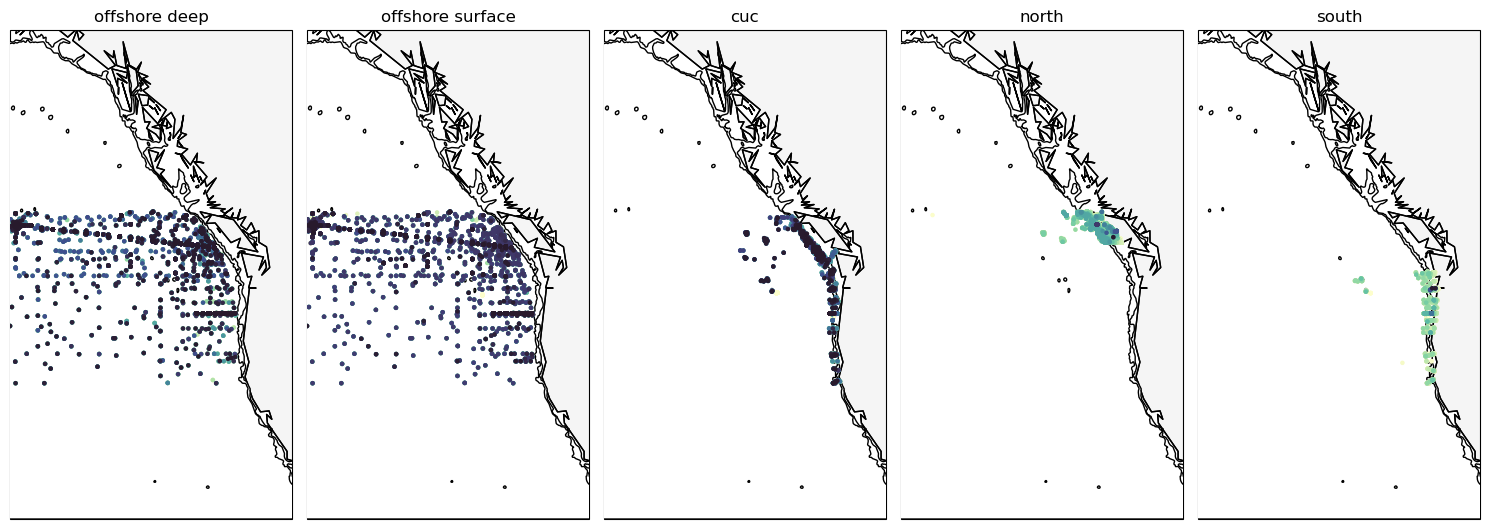

In [31]:
regions = ['offshore deep','offshore surface', 'cuc', 'north', 'south']

#elipse information
# x_mean, y_mean, width, height, angle = np.zeros(len(regions)), np.zeros(len(regions)), np.zeros(len(regions)), np.zeros(len(regions)), np.zeros(len(regions))

fig, ax = plt.subplots(1,len(regions),figsize=[len(regions)*3,3])
for i in range(len(ax)):
    TS(sob,regions[i],ax[i],'salinity (g kg-1)','temperature (degC)')
    confidence_ellipse(np.array(sob['salinity (g kg-1)'][sob.region == regions[i]]), np.array(sob['temperature (degC)'][sob.region == regions[i]]), ax[i], n_std=2, edgecolor='red')
    ell = percentile_ellipse(np.array(sob['salinity (g kg-1)'][sob.region == regions[i]]), np.array(sob['temperature (degC)'][sob.region == regions[i]]), ax[i], percentile=75, facecolor='none',edgecolor='green')
    ax[i].add_patch(ell)
    percentile_mode_ellipse(np.array(sob['salinity (g kg-1)'][sob.region == regions[i]]), np.array(sob['temperature (degC)'][sob.region == regions[i]]), ax[i], percentile=75,facecolor='none', edgecolor='yellow')


# show boundaries from CIOPS analysis
ax[2].plot([33.9,33.9],[tmin,tmax],'r--', alpha=0.7, label='Deep division')
ax[2].plot([32,32],[tmin,tmax],'g--',alpha=0.7,label='Columbia division')
ax[4].plot([33.9,33.9],[tmin,tmax],'r--', alpha=0.7, label='Deep division')
ax[4].plot([32,32],[tmin,tmax],'g--',alpha=0.7,label='Columbia division')
plt.tight_layout()

# Nitrate - Salinity
#elipse information
NSx_mean, NSy_mean, NSwidth, NSheight, NSangle = np.zeros(len(regions)), np.zeros(len(regions)), np.zeros(len(regions)), np.zeros(len(regions)), np.zeros(len(regions))

fig, ax = plt.subplots(1,len(regions),figsize=[len(regions)*3,3])
for i in range(len(ax)):
    TS(sob,regions[i],ax[i],'salinity (g kg-1)','NO3 (uM)')
    ell = percentile_ellipse(np.array(sob['salinity (g kg-1)'][sob.region == regions[i]]), np.array(sob['NO3 (uM)'][sob.region == regions[i]]), ax[i], percentile=50, facecolor='none', edgecolor='green')
    ax[i].add_patch(ell)
plt.tight_layout()

# TA - Salinity
#elipse information
TASx_mean, TASy_mean, TASwidth, TASheight, TASangle = np.zeros(len(regions)), np.zeros(len(regions)), np.zeros(len(regions)), np.zeros(len(regions)), np.zeros(len(regions))

fig, ax = plt.subplots(1,len(regions),figsize=[len(regions)*3,3])
for i in range(len(ax)):
    TS(sob,regions[i],ax[i],'salinity (g kg-1)','TA (uM)')
    ell = percentile_ellipse(np.array(sob['salinity (g kg-1)'][sob.region == regions[i]]), np.array(sob['TA (uM)'][sob.region == regions[i]]), ax[i], percentile=50, facecolor='none', edgecolor='green')
    ax[i].add_patch(ell)
plt.tight_layout()

# TS coloured by depth
fig, ax = plt.subplots(1,len(regions),figsize=[len(regions)*3,3])
for i in range(len(ax)):
    TS_depth(sob,regions[i],ax[i])

# show boundaries from CIOPS analysis
ax[2].plot([33.9,33.9],[tmin,tmax],'r--', alpha=0.7, label='Deep division')
ax[2].plot([32,32],[tmin,tmax],'g--',alpha=0.7,label='Columbia division')
ax[4].plot([33.9,33.9],[tmin,tmax],'r--', alpha=0.7, label='Deep division')
ax[4].plot([32,32],[tmin,tmax],'g--',alpha=0.7,label='Columbia division')
plt.tight_layout()

xlim, ylim = [-145.5, -120.2], [30, 60]
fig, ax = plt.subplots(1,5, figsize=(len(regions)*3,6), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})
for i in range(len(ax)):
    xy_depth(sob,regions[i],ax[i])
plt.tight_layout()

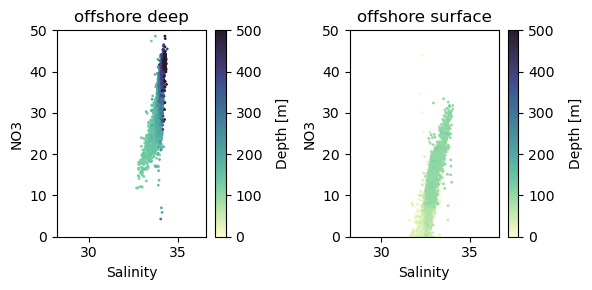

In [32]:
# ok i think its worth digging into those two groups that show up in the offshore plot of NO3-salinity

# no3-salinity space, coloured by depth
smin, smax = 28.2,36.6
nmin, nmax = 0,50
fig, ax = plt.subplots(1,2,figsize=[6,3])

r = ['offshore deep', 'offshore surface']
for i in range(len(r)):
    salt = sob['salinity (g kg-1)'][(sob.region == r[i])].reset_index(drop=True)
    no3 = sob['NO3 (uM)'][(sob.region == r[i])].reset_index(drop=True)
    z = sob['depth (m)'][(sob.region == r[i])].reset_index(drop=True)

    # Sort the points by depth, so that the deepest points are plotted last
    idx = z.argsort()
    salt, no3, z = salt[idx], no3[idx], z[idx]
                    
    sc = ax[i].scatter(salt,no3, c=z, cmap=cm.cm.deep,s=1,vmin=0,vmax=500)
    cb = fig.colorbar(sc, ax=ax[i])
    cb.set_label('Depth [m]', labelpad=10, fontsize=10)

    ax[i].set_title(r[i])
    
    ax[i].set_ylabel('NO3')
    ax[i].set_xlabel('Salinity')

    ax[i].set_ylim([nmin,nmax])
    ax[i].set_xlim([smin,smax])
plt.tight_layout()

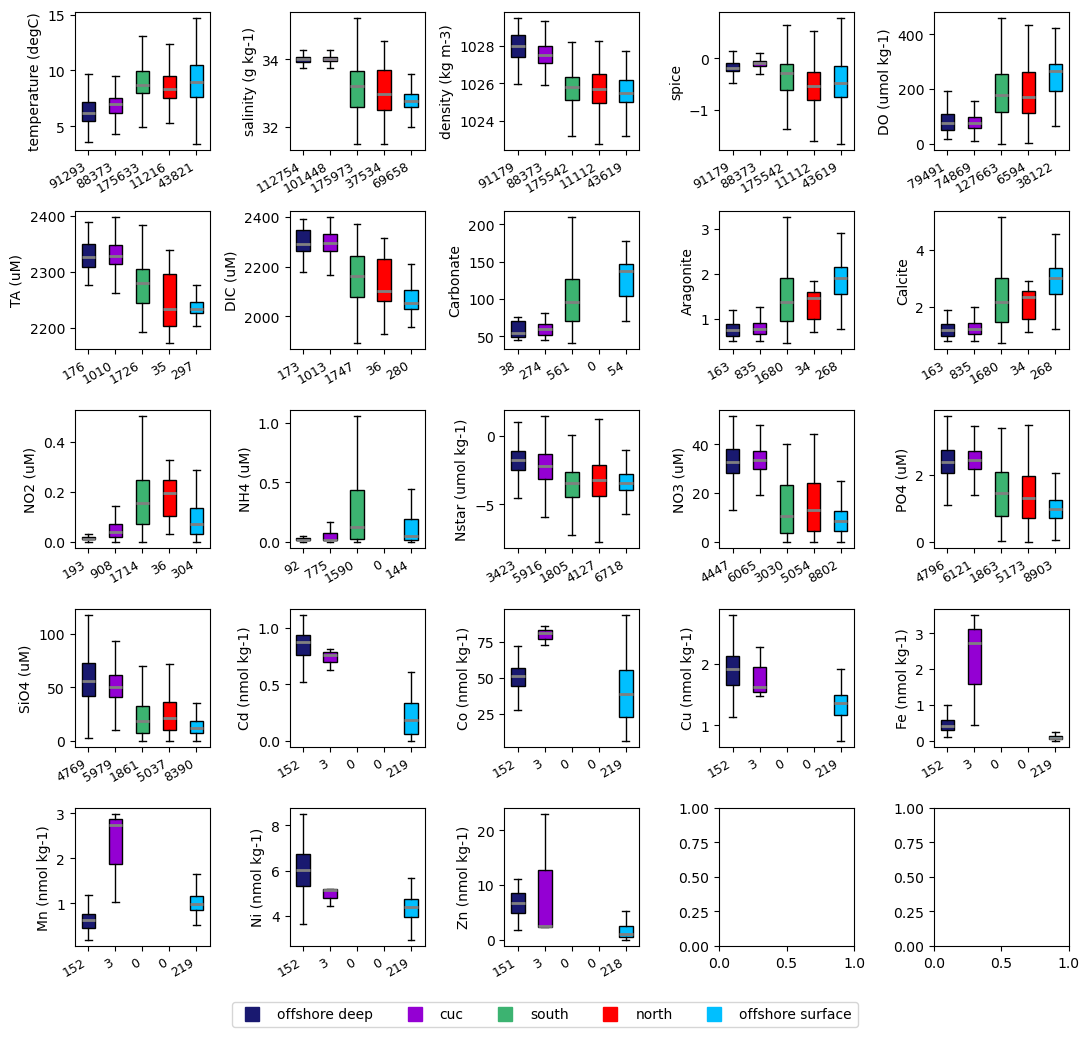

In [35]:
# box plots of different tracers
regions = ['offshore deep', 'cuc', 'south', 'north', 'offshore surface']
colour = ['midnightblue','darkviolet','mediumseagreen','red','deepskyblue']

fig, ax = plt.subplots(5,5,figsize=[11,10])

properties = ['temperature (degC)','salinity (g kg-1)','density (kg m-3)','spice','DO (umol kg-1)']
for i in range(len(properties)):
    bplot = box(sob,regions,properties[i],ax[0,i])
    for patch, color in zip(bplot['boxes'], colour):
        patch.set_facecolor(color)
    for median in bplot['medians']:
        median.set_color('grey')
        median.set_linewidth(2)

properties = ['TA (uM)','DIC (uM)','Carbonate','Aragonite', 'Calcite']
for i in range(len(properties)):
    bplot = box(sob,regions,properties[i],ax[1,i])
    for patch, color in zip(bplot['boxes'], colour):
        patch.set_facecolor(color)
    for median in bplot['medians']:
        median.set_color('grey')
        median.set_linewidth(2)

properties = ['NO2 (uM)','NH4 (uM)','Nstar (umol kg-1)','NO3 (uM)','PO4 (uM)']
for i in range(len(properties)):
    bplot = box(sob,regions,properties[i],ax[2,i])
    for patch, color in zip(bplot['boxes'], colour):
        patch.set_facecolor(color)
    for median in bplot['medians']:
        median.set_color('grey')
        median.set_linewidth(2)

# ## To indicate significance
# ax[1,0].plot([1, 1, 3, 3], [52, 54, 54, 49], linewidth=1, color='grey')
# ax[1,0].text(2, 47, "*", ha='center', va='bottom', color='grey',fontsize=10)
# ax[1,0].plot([4, 4, 5, 5], [0, -2, -2, 0], linewidth=1, color='grey')
# ax[1,0].text(4.5, -4, "*", ha='center', va='bottom', color='grey',fontsize=10)


properties = ['SiO4 (uM)', 'Cd (nmol kg-1)','Co (nmol kg-1)','Cu (nmol kg-1)','Fe (nmol kg-1)']
for i in range(len(properties)):
    bplot = box(sob,regions,properties[i],ax[3,i])
    for patch, color in zip(bplot['boxes'], colour):
        patch.set_facecolor(color)
    for median in bplot['medians']:
        median.set_color('grey')
        median.set_linewidth(2)

properties = ['Mn (nmol kg-1)','Ni (nmol kg-1)', 'Zn (nmol kg-1)']
for i in range(len(properties)):
    bplot = box(sob,regions,properties[i],ax[4,i])
    for patch, color in zip(bplot['boxes'], colour):
        patch.set_facecolor(color)
    for median in bplot['medians']:
        median.set_color('grey')
        median.set_linewidth(2)

# build legend handles    
legend_handles = []
for i in range(len(regions)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker='s', linestyle='None',markersize=10,
                          markeredgecolor=colour[i], markerfacecolor=colour[i],
                          label=regions[i]))
# Add a figure-wide legend below the subplots
fig.legend(handles=legend_handles, loc='upper center', ncol=5, bbox_to_anchor=(0.5, -0.001), frameon=True)

plt.tight_layout()
    


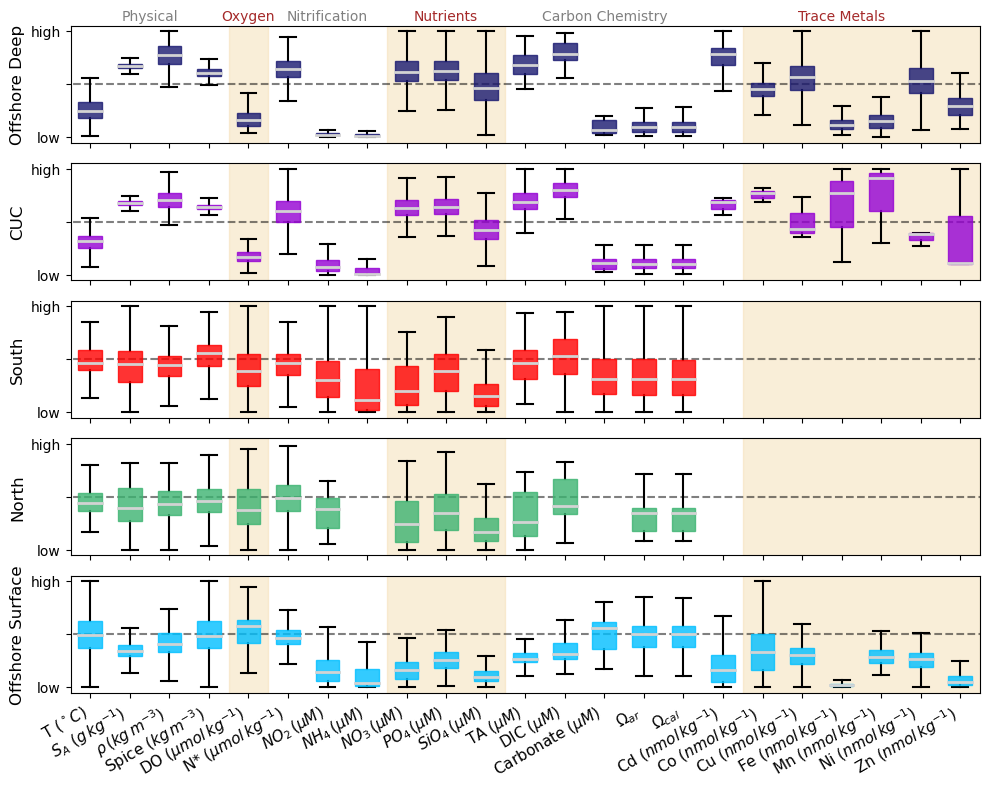

In [59]:
regions = ['offshore deep','cuc','south','north','offshore surface']
colour = ['midnightblue','darkviolet',  'r', 'mediumseagreen', 'deepskyblue']

data = sob
properties = ['temperature (degC)','salinity (g kg-1)','density (kg m-3)','spice','DO (umol kg-1)', 
              'Nstar (umol kg-1)','NO2 (uM)','NH4 (uM)','NO3 (uM)','PO4 (uM)','SiO4 (uM)', 'TA (uM)',
              'DIC (uM)','Carbonate','Aragonite', 'Calcite','Cd (nmol kg-1)','Co (nmol kg-1)',
              'Cu (nmol kg-1)','Fe (nmol kg-1)','Mn (nmol kg-1)','Ni (nmol kg-1)', 'Zn (nmol kg-1)']

# Function to calculate boxplot statistics
def calculate_boxplot_statistics(data, up, down,prop, region):
    region_data = data[data['region'] == region][prop].dropna()
    up_data = up[up['region'] == region][prop].dropna()
    down_data = down[down['region'] == region][prop].dropna()

    if len(region_data)>0:
        Q1 = np.percentile(region_data, 25)
        Q3 = np.percentile(region_data, 75)
        IQR = Q3 - Q1
        whisker_min = max(region_data.min(), Q1 - 1.5 * IQR)
        whisker_max = min(region_data.max(), Q3 + 1.5 * IQR)
        median = np.median(region_data)
        mean = np.mean(region_data)
        up_mean = np.mean(up_data)
        up_median = np.median(up_data)
        down_mean = np.mean(down_data)
        down_median = np.median(down_data)
    else:
        Q1 = np.nan
        Q3 = np.nan
        whisker_min = np.nan
        whisker_max = np.nan
        median = np.nan
        mean = np.nan
        up_mean = np.nan
        up_median = np.nan
        down_mean = np.nan
        down_median = np.nan
    return {
        'whisker_min': whisker_min,
        'Q1': Q1,
        'median': median,
        'mean': mean,
        'Q3': Q3,
        'whisker_max': whisker_max,
        'up_mean': up_mean,
        'up_median': up_median,
        'down_mean': down_mean,
        'down_median': down_median
    }

# Collect boxplot statistics for all regions and properties
boxplot_statistics = {prop: {region: calculate_boxplot_statistics(data, sob, wob, prop, region) for region in regions} for prop in properties}

# Normalize the statistics for plotting
normalized_statistics = {}
for prop in properties:
    # Gather all values to determine the global min and max for normalization
    all_values = []
    for region, statistics in boxplot_statistics[prop].items():
        all_values.extend([statistics['whisker_min'], statistics['Q1'], statistics['median'], statistics['mean'], statistics['Q3'], statistics['whisker_max'],
                            statistics['up_mean'], statistics['up_median'],statistics['down_mean'],statistics['down_median']])
    
    global_min = min(all_values)
    global_max = max(all_values)
    
    # Normalize all statistics using the same range
    normalized_statistics[prop] = {
        region: {
            key: (value - global_min) / (global_max - global_min)
            for key, value in statistics.items()
        }
        for region, statistics in boxplot_statistics[prop].items()
    }

# Plot normalized boxplots manually
fig, axes = plt.subplots(len(regions), 1, figsize=(10, 8), sharex=True)

for i, region in enumerate(regions):
    ax = axes[i]
    box_data = []
    for prop in properties:
        statistics = normalized_statistics[prop][region]
        box_data.append([
            statistics['whisker_min'], statistics['Q1'], statistics['median'], statistics['mean'], statistics['Q3'], statistics['whisker_max'],
            statistics['up_mean'], statistics['up_median'],statistics['down_mean'],statistics['down_median']
        ])
    
    # Manual construction of boxplot
    for j, statistics in enumerate(box_data):
        x = j + 1
        ax.plot([x, x], [statistics[0], statistics[1]], color='black',zorder=2)  # Lower whisker
        ax.plot([x, x], [statistics[4], statistics[5]], color='black',zorder=2)  # Upper whisker
        ax.plot([x - 0.2, x + 0.2], [statistics[0], statistics[0]], color='black',zorder=2)  # Lower cap
        ax.plot([x - 0.2, x + 0.2], [statistics[5], statistics[5]], color='black',zorder=2)  # Upper cap
        ax.add_patch(plt.Rectangle((x - 0.3, statistics[1]), 0.6, statistics[4] - statistics[1], color=colour[i], alpha=0.8,zorder=3))  # Box
        ax.plot([x - 0.3, x + 0.3], [statistics[2], statistics[2]], color='lightgrey', linewidth=2,zorder=4)  # Median
        # ax.plot([x - 0.3, x + 0.3], [statistics[3], statistics[3]], color='grey', ls='dotted', linewidth=2,zorder=4)  # Mean

    
    ax.set_xticks(range(1, len(properties) + 1))
    prop_name = ['T ($^\circ C$)','$S_A$ ($g\,kg^{-1}$)',r'$\rho \,(kg\,m^{-3})$','Spice $(kg\,m^{-3})$','DO ($\mu mol\,kg^{-1}$)', 
              'N* ($\mu mol\,kg^{-1}$)','$NO_2\,(\mu M)$','$NH_4\,(\mu M)$','$NO_3\,(\mu M)$', '$PO_4\,(\mu M)$', '$SiO_4\,(\mu M)$', 'TA $(\mu M)$',
              'DIC $(\mu M)$', 'Carbonate $(\mu M)$','$\Omega_{ar}$', '$\Omega_{cal}$','Cd ($nmol\,kg^{-1}$)','Co ($nmol\,kg^{-1}$)',
              'Cu ($nmol\,kg^{-1}$)','Fe ($nmol\,kg^{-1}$)','Mn ($nmol\,kg^{-1}$)','Ni ($nmol\,kg^{-1}$)', 'Zn ($nmol\,kg^{-1}$)']
    ax.set_xticklabels(prop_name,rotation=30,ha='right',fontsize=11)
    ax.set_yticks([0,0.5,1])
    ax.set_yticklabels(['low',' ','high'])

    ax.set_xlim([0.5,len(properties)+0.5])
    ax.set_ylim([-0.05,1.05])
    ax.plot([0,len(properties)+1],[0.5,0.5],'k--',zorder=1,alpha=0.5)

    # tracer categories
    # ax.fill_between(np.arange(0,len(properties)+1,0.5), -0.1, 1.1, where=(np.arange(0,len(properties)+1,0.5)<=4.5)&(np.arange(0,len(properties)+1,0.5)>=0), color='wheat', alpha=0.5, zorder=0)
    # ax.fill_between(np.arange(0,len(properties)+1,0.5), -0.1, 1.1, where=(np.arange(0,len(properties)+1,0.5)<=8.5)&(np.arange(0,len(properties)+1,0.5)>=5.5), color='wheat', alpha=0.5, zorder=0)
    # ax.fill_between(np.arange(0,len(properties)+1,0.5), -0.1, 1.1, where=(np.arange(0,len(properties)+1,0.5)<=18)&(np.arange(0,len(properties)+1,0.5)>=11.5), color='wheat', alpha=0.5, zorder=0)
    ax.fill_between(np.arange(0,len(properties)+1,0.5), -0.1, 1.1, where=(np.arange(0,len(properties)+1,0.5)<=5.5)&(np.arange(0,len(properties)+1,0.5)>=4.5), color='wheat', alpha=0.5, zorder=0)
    ax.fill_between(np.arange(0,len(properties)+1,0.5), -0.1, 1.1, where=(np.arange(0,len(properties)+1,0.5)<=11.5)&(np.arange(0,len(properties)+1,0.5)>=8.5), color='wheat', alpha=0.5, zorder=0)
    ax.fill_between(np.arange(0,len(properties)+1,0.5), -0.1, 1.1, where=(np.arange(0,len(properties)+1,0.5)<=25.5)&(np.arange(0,len(properties)+1,0.5)>=17.5), color='wheat', alpha=0.5, zorder=0)



# region labels
axes[0].set_ylabel('Offshore Deep',fontsize=12)
axes[1].set_ylabel('CUC',fontsize=12)
axes[2].set_ylabel('South',fontsize=12)
axes[3].set_ylabel('North',fontsize=12)
axes[4].set_ylabel('Offshore Surface',fontsize=12)

# text above the top plot to label tracer categories
axes[0].text(2.5, 1.1, "Physical", ha='center', color='grey', fontsize=10)
axes[0].text(5, 1.1, "Oxygen", ha='center', color='brown', fontsize=10)
axes[0].text(7, 1.1, "Nitrification", ha='center', color='grey', fontsize=10)
axes[0].text(10, 1.1, "Nutrients", ha='center', color='brown', fontsize=10)
axes[0].text(14, 1.1, "Carbon Chemistry", ha='center', color='grey', fontsize=10)
axes[0].text(20, 1.1, "Trace Metals", ha='center', color='brown', fontsize=10)


plt.tight_layout()

### Statistics

In [37]:
properties = ['temperature (degC)','salinity (g kg-1)','density (kg m-3)','spice','DO (umol kg-1)', 
              'Nstar (umol kg-1)','NO3 (uM)','NO2 (uM)','NH4 (uM)', 'PO4 (uM)', 'SiO4 (uM)', 'TA (uM)',
              'DIC (uM)', 'Carbonate','Aragonite', 'Calcite']

alpha = 0.05

for prop in properties:
    print(prop)
    # Filter out NaN values and exclude 'none' and 'brackish' regions
    obs_filtered = sob.dropna(subset=[prop])
    obs_filtered = obs_filtered[~obs_filtered['region'].isin(['none', 'brackish'])]

    # Perform one-way ANOVA
    groups = [obs_filtered[obs_filtered['region'] == region][prop] for region in ['cuc', 'offshore deep', 'offshore surface', 'south', 'north']]
    anova_result = stats.f_oneway(*groups)

    # Output ANOVA result
    if anova_result.pvalue < alpha:
        print(f"Significant differences found between regions (p = {anova_result.pvalue:.4f}) at α = {alpha}.\n")
        
        # Perform Tukey HSD test for post hoc analysis
        tukey_result = pairwise_tukeyhsd(endog=obs_filtered[prop], groups=obs_filtered['region'], alpha=alpha)
        
        # Extract Tukey results into a DataFrame
        tukey_df = pd.DataFrame(data=tukey_result._results_table.data[1:], columns=tukey_result._results_table.data[0]).drop(['p-adj','lower','upper'],axis=1)
        
        # Calculate Cohen's d and OVL for each pair of regions
        additional_results = []
        for i, row in tukey_df.iterrows():
            region1, region2 = row['group1'], row['group2']
            data1 = obs_filtered[obs_filtered['region'] == region1][prop]
            data2 = obs_filtered[obs_filtered['region'] == region2][prop]
            
            # Cohen's d calculation
            mean_diff = np.mean(data1) - np.mean(data2)
            pooled_std = np.sqrt((np.var(data1, ddof=1) + np.var(data2, ddof=1)) / 2)
            cohens_d = mean_diff / pooled_std if pooled_std != 0 else np.nan
            
            # Overlap Coefficient (OVL) calculation
            overlap_coef = 2 * stats.norm.cdf(-abs(cohens_d) / 2) if not np.isnan(cohens_d) else np.nan
            
            additional_results.append((cohens_d, overlap_coef))
        
        # Add Cohen's d and OVL to the DataFrame
        tukey_df[['Cohen\'s d', 'OVL']] = additional_results
        print("Tukey HSD post hoc results with Cohen's d and OVL:")
        print(tukey_df)
    else:
        print(f"No significant differences between regions (p = {anova_result.pvalue:.8f}) at α = {alpha}.")
    print('\n')

temperature (degC)


Significant differences found between regions (p = 0.0000) at α = 0.05.

Tukey HSD post hoc results with Cohen's d and OVL:
             group1            group2  meandiff  reject  Cohen's d       OVL
0               cuc             north    2.0458    True  -1.329433  0.506232
1               cuc     offshore deep   -0.4860    True   0.443210  0.824621
2               cuc  offshore surface    2.2767    True  -0.996538  0.618294
3               cuc             south    2.4329    True  -1.639065  0.412483
4             north     offshore deep   -2.5318    True   1.629165  0.415311
5             north  offshore surface    0.2309    True  -0.091037  0.963694
6             north             south    0.3871    True  -0.209431  0.916602
7     offshore deep  offshore surface    2.7626    True  -1.203853  0.547223
8     offshore deep             south    2.9188    True  -1.945851  0.330590
9  offshore surface             south    0.1562    True  -0.062390  0.975114


salinity (g kg-1)
Significa

In [38]:
all_prop= ['temperature (degC)', 'salinity (g kg-1)', 'DO (umol kg-1)', 'NO3 (uM)',
       'NO2 (uM)', 'NH4 (uM)', 'PO4 (uM)', 'SiO4 (uM)', 'Chl (mg m-3)',
       'TA (uM)', 'DIC (uM)', 'Carbonate', 'Aragonite', 'Calcite',
       'Cd (nmol kg-1)', 'Co (nmol kg-1)', 'Cu (nmol kg-1)', 'Fe (nmol kg-1)',
       'Mn (nmol kg-1)', 'Ni (nmol kg-1)', 'Zn (nmol kg-1)','Nstar (umol kg-1)', 
       'spice', 'density (kg m-3)']

print(regions)
for prop in all_prop:
    # print in the same format as a latex table
    print('{} &{} ({}) &{} ({}) &{} ({}) &{} ({}) &{} ({}) \\'.format(prop,
                np.round(np.nanmean(sob[prop][(sob.region == regions[0])]),1),np.round(np.nanstd(sob[prop][(sob.region == regions[0])]),1),
                np.round(np.nanmean(sob[prop][(sob.region == regions[1])]),1),np.round(np.nanstd(sob[prop][(sob.region == regions[1])]),1),
                np.round(np.nanmean(sob[prop][(sob.region == regions[2])]),1),np.round(np.nanstd(sob[prop][(sob.region == regions[2])]),1),
                np.round(np.nanmean(sob[prop][(sob.region == regions[3])]),1),np.round(np.nanstd(sob[prop][(sob.region == regions[3])]),1),
                np.round(np.nanmean(sob[prop][(sob.region == regions[4])]),1),np.round(np.nanstd(sob[prop][(sob.region == regions[4])]),1)))
    # print("\n")

['offshore deep', 'cuc', 'south', 'north', 'offshore surface']
temperature (degC) &6.3 (1.1) &6.8 (1.1) &9.2 (1.8) &8.9 (1.9) &9.1 (3.0) \
salinity (g kg-1) &34.0 (0.2) &34.0 (0.2) &33.1 (0.6) &33.0 (0.7) &32.9 (0.6) \
DO (umol kg-1) &82.9 (40.6) &79.7 (31.3) &183.2 (81.4) &182.0 (82.7) &241.3 (68.6) \
NO3 (uM) &32.6 (6.7) &33.5 (5.3) &13.6 (11.1) &14.5 (11.1) &8.9 (6.2) \
NO2 (uM) &0.0 (0.0) &0.1 (0.1) &0.2 (0.1) &0.2 (0.1) &0.1 (0.1) \
NH4 (uM) &0.0 (0.1) &0.1 (0.2) &0.4 (0.8) &nan (nan) &0.2 (0.4) \
PO4 (uM) &2.4 (0.5) &2.4 (0.4) &1.4 (0.8) &1.3 (0.7) &1.0 (0.4) \
SiO4 (uM) &58.1 (20.6) &53.1 (15.9) &21.6 (16.8) &23.7 (16.1) &13.2 (8.6) \
Chl (mg m-3) &0.1 (0.3) &0.0 (0.1) &3.4 (3.7) &3.4 (4.5) &0.7 (0.7) \
TA (uM) &2331.6 (26.5) &2331.7 (23.8) &2274.4 (35.7) &2246.9 (51.3) &2240.0 (22.6) \
DIC (uM) &2302.1 (51.8) &2297.5 (47.5) &2156.9 (101.8) &2136.7 (97.8) &2076.0 (66.3) \
Carbonate &58.9 (10.8) &60.6 (10.9) &101.3 (37.1) &nan (nan) &127.1 (28.8) \
Aragonite &0.8 (0.2) &0.8 (0.2)

In [39]:
# other observations of tracer metals:

######################
# SALISH SEA or WCVI #
######################

# from Kuang et al. (2022) Factors controlling the temporal variability and spatial distribution of dissolved cadmium in the coastal Salish Sea
# at the JF2 mooring in JdF
cd_JF2_surface = 700/1000 # nmol/kg
cd_JF2_150m = 800/1000 # nmol/kg 

# from King et al. (2023) Polycyclic aromatic compound and trace metal element residues in Mytilus mussels at marine wildlife hotspots on the Pacific coast of Canada
# NOTE: results are from mussel soft tissue, not straight from water - but since these metals don't bioaccumulate much can we take them as a marker for water concentrations? - NOPE WAY TOO HIGH
# assuming mussels are mostly water, lets convert to nmol/kg 
# mandarte island in haro straight
cd_mand = (3.3 * (10**6))/112.41  # ug/g
cu_mand = (6.9 * (10**6))/63.546 # ug/g
ni_mand = (1.2 * (10**6))/58.69 # ug/g
zn_mand = (118 * (10**6))/65.38 # ug/g
# cleland island on the WCVI
cd_clel = (10.5 * (10**6))/112.41 # ug/g
cu_clel = (6.7 * (10**6))/63.546 # ug/g
ni_clel = (2.5 * (10**6))/58.69 # ug/g
zn_clel = (172 * (10**6))/65.38 # ug/g

##############
# NE PACIFIC #
##############

# from Bruland (1979) OCEANOGRAPHIC DISTRIBUTIONS OF CADMIUM, ZINC, NICKEL, AND COPPER IN THE NORTH PACIFIC
# offshore of san francisco profile site C-I March 1978, 37°0.0'N, 124°12.0'W
cd_CI_75 = 0.29 # nmol/kg
cd_CI_490 = 1.04 # nmol/kg
cu_CI_75 = 1.35 # nmol/kg
cu_CI_490 = 1.53 # nmol/kg
ni_CI_75 = 4.34 # nmol/kg
ni_CI_490 = 7.19 # nmol/kg
zn_CI_75 = 1.27 # nmol/kg
zn_CI_490 = 5.37 # nmol/kg

# from Landing & Bruland (1985) The contrasting biogeochemistry of iron and manganese in the Pacific Ocean
# same location as profiles from above source but from VERTEX cruise
mn_VI_0_250 = 1.73 # nmol/kg
mn_VI_0_750 = 1.34 # nmol/kg
fe_VI_0_250 = 1.31 # nmol/kg
fe_VI_0_750 = 1.96 # nmol/kg


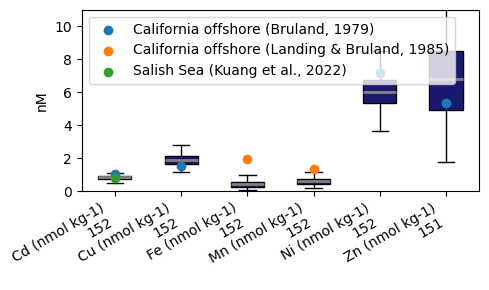

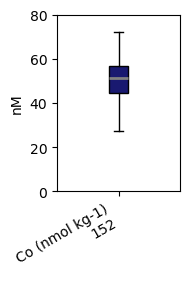

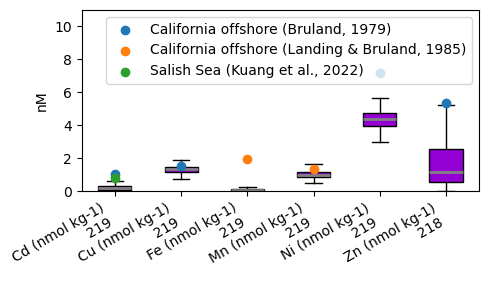

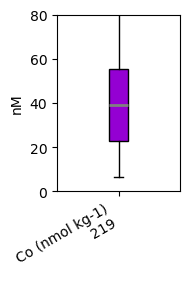

In [40]:
# box plot of just the offshore trace metals compared to what we get in the salish sea or what we expect in the pacific

properties = ['Cd (nmol kg-1)','Cu (nmol kg-1)','Fe (nmol kg-1)','Mn (nmol kg-1)','Ni (nmol kg-1)', 'Zn (nmol kg-1)'] # put Co (nM ) on another axis
fig, ax = plt.subplots(1,1,figsize=[5,3])

tracer = [sob[prop][sob.region=='offshore deep'] for prop in properties]

# Filter data using np.isnan (boxplots can't really handle nans)
t_filter = [tracer[i][~np.isnan(tracer[i])] for i in range(len(tracer))]

bplot = ax.boxplot(t_filter, showfliers=False, patch_artist=True)


ticks = ["{}\n{}".format(properties[i],str(len(t_filter[i]))) for i in range(len(properties))]
ax.set_xticklabels(ticks,rotation=30,ha='right')
ax.set_ylabel('nM')
ax.set_ylim([0,11])

for patch in bplot['boxes']:
    patch.set_facecolor(colour[0])
for median in bplot['medians']:
    median.set_color('grey')
    median.set_linewidth(2)
plt.tight_layout()

# plot other measures of the trace metals
ax.scatter([1,2,5,6],[cd_CI_490,cu_CI_490,ni_CI_490,zn_CI_490],label='California offshore (Bruland, 1979)',zorder=5)
ax.scatter([3,4],[fe_VI_0_750,mn_VI_0_750],label='California offshore (Landing & Bruland, 1985)',zorder=5)
ax.scatter(1,cd_JF2_150m,label='Salish Sea (Kuang et al., 2022)',zorder=5)
ax.legend()

# colbalt separate bc soooo much higher
properties=['Co (nmol kg-1)']

fig, ax = plt.subplots(1,1,figsize=[2,3])

tracer = [sob[prop][sob.region=='offshore deep'] for prop in properties]

# Filter data using np.isnan (boxplots can't really handle nans)
t_filter = [tracer[i][~np.isnan(tracer[i])] for i in range(len(tracer))]

bplot = ax.boxplot(t_filter, showfliers=False, patch_artist=True)
ticks = ["{}\n{}".format(properties[i],str(len(t_filter[i]))) for i in range(len(properties))]
ax.set_xticklabels(ticks,rotation=30,ha='right')
ax.set_ylabel('nM')
ax.set_ylim([0,80])

for patch in bplot['boxes']:
    patch.set_facecolor(colour[0])
for median in bplot['medians']:
    median.set_color('grey')
    median.set_linewidth(2)
plt.tight_layout()






# for surface
properties = ['Cd (nmol kg-1)','Cu (nmol kg-1)','Fe (nmol kg-1)','Mn (nmol kg-1)','Ni (nmol kg-1)', 'Zn (nmol kg-1)'] # put Co (nM ) on another axis

fig, ax = plt.subplots(1,1,figsize=[5,3])

tracer = [sob[prop][sob.region=='offshore surface'] for prop in properties]

# Filter data using np.isnan (boxplots can't really handle nans)
t_filter = [tracer[i][~np.isnan(tracer[i])] for i in range(len(tracer))]

bplot = ax.boxplot(t_filter, showfliers=False, patch_artist=True)


ticks = ["{}\n{}".format(properties[i],str(len(t_filter[i]))) for i in range(len(properties))]
ax.set_xticklabels(ticks,rotation=30,ha='right')
ax.set_ylabel('nM')
ax.set_ylim([0,11])


for patch in bplot['boxes']:
    patch.set_facecolor(colour[1])
for median in bplot['medians']:
    median.set_color('grey')
    median.set_linewidth(2)
plt.tight_layout()

# plot other measures of the trace metals
ax.scatter([1,2,5,6],[cd_CI_490,cu_CI_490,ni_CI_490,zn_CI_490],label='California offshore (Bruland, 1979)',zorder=5)
ax.scatter([3,4],[fe_VI_0_750,mn_VI_0_750],label='California offshore (Landing & Bruland, 1985)',zorder=5)
ax.scatter(1,cd_JF2_150m,label='Salish Sea (Kuang et al., 2022)',zorder=5)
ax.legend()

# colbalt separate bc soooo much higher
properties=['Co (nmol kg-1)']

fig, ax = plt.subplots(1,1,figsize=[2,3])

tracer = [sob[prop][sob.region=='offshore surface'] for prop in properties]

# Filter data using np.isnan (boxplots can't really handle nans)
t_filter = [tracer[i][~np.isnan(tracer[i])] for i in range(len(tracer))]

bplot = ax.boxplot(t_filter, showfliers=False, patch_artist=True)
ticks = ["{}\n{}".format(properties[i],str(len(t_filter[i]))) for i in range(len(properties))]
ax.set_xticklabels(ticks,rotation=30,ha='right')
ax.set_ylabel('nM')
ax.set_ylim([0,80])


for patch in bplot['boxes']:
    patch.set_facecolor(colour[1])
for median in bplot['medians']:
    median.set_color('grey')
    median.set_linewidth(2)
plt.tight_layout()

## Winter

In [41]:
# WINTER DIVISIONS

# really just south water important in the winter so i think the results will be less sensitive to N/S spatial divisions
# i'm also less worried about the JdF Eddy, so maybe its ok to take points near the entrance to the salish sea

# CUC = slope water south of 50.5 & salinity greater than or equal to 33.8 (need to do sensitivity analysis on this salinity choice)
# north shelf = shelf water north of 50.5, slope water north of 50.5 in the top 200 m
# south shelf = shelf water south of 50.5, slope water south of 50.5 with salinity less than 33.8
# brackish = salinity less than or equal to 32
# offshore = offshore of 2000 m contour

wob['region'] = 'none'
wob.region[(wob.location == 'offshore') & (wob['depth (m)']>=120)] = 'offshore deep'
wob.region[(wob.location == 'offshore') & (wob['depth (m)']<120)] = 'offshore surface'
wob.region[(wob.location == 'shelf') & (wob['latitude (degrees_north)'] >= 49)] = 'north'
wob.region[(wob.location == 'shelf') & (wob['latitude (degrees_north)'] <= 47.3)] = 'south'
wob.region[(wob.location == 'slope') & (wob['latitude (degrees_north)'] >= 49) & (wob['depth (m)'] <= 200)] = 'north'
wob.region[(wob.location == 'slope') & (wob['latitude (degrees_north)'] <= 47.3) & (wob['salinity (g kg-1)'] < 33.7)] = 'south'
wob.region[(wob.location == 'slope') & (wob['latitude (degrees_north)'] <= 50.5) & (wob['salinity (g kg-1)'] >= 33.7)] = 'cuc'
wob.region[wob['salinity (g kg-1)'] <= 31.5] = 'brackish' # putting this one last will remove the <32 points from the other regions

In [42]:
# count the number of observations for each variable
properties = ['temperature (degC)', 'salinity (g kg-1)', 'DO (umol kg-1)', 'NO3 (uM)',
       'NO2 (uM)', 'NH4 (uM)', 'PO4 (uM)', 'SiO4 (uM)',
       'TA (uM)', 'DIC (uM)', 'Carbonate', 'Aragonite', 'Calcite',
       'Cd (nmol kg-1)', 'Co (nmol kg-1)', 'Cu (nmol kg-1)', 'Fe (nmol kg-1)',
       'Mn (nmol kg-1)', 'Ni (nmol kg-1)', 'Zn (nmol kg-1)']
regions = ['offshore deep','offshore surface', 'cuc', 'north', 'south']

for reg in regions:
    print(reg)
    for prop in properties:
        print("{}= {}".format(prop,len(wob[(wob.region == reg) & ~np.isnan(wob[prop])])))
        # print(list(set(wob.source[(wob.region == reg) & ~np.isnan(wob[prop])])))
    print("\n")

offshore deep
temperature (degC)= 34788
salinity (g kg-1)= 45852
DO (umol kg-1)= 31053
NO3 (uM)= 1474
NO2 (uM)= 0
NH4 (uM)= 0
PO4 (uM)= 1584
SiO4 (uM)= 1605
TA (uM)= 0
DIC (uM)= 0
Carbonate= 0
Aragonite= 0
Calcite= 0
Cd (nmol kg-1)= 31
Co (nmol kg-1)= 31
Cu (nmol kg-1)= 31
Fe (nmol kg-1)= 31
Mn (nmol kg-1)= 31
Ni (nmol kg-1)= 31
Zn (nmol kg-1)= 31


offshore surface
temperature (degC)= 17912
salinity (g kg-1)= 28334
DO (umol kg-1)= 17117
NO3 (uM)= 2579
NO2 (uM)= 0
NH4 (uM)= 0
PO4 (uM)= 2585
SiO4 (uM)= 2445
TA (uM)= 0
DIC (uM)= 0
Carbonate= 0
Aragonite= 0
Calcite= 0
Cd (nmol kg-1)= 53
Co (nmol kg-1)= 53
Cu (nmol kg-1)= 53
Fe (nmol kg-1)= 53
Mn (nmol kg-1)= 53
Ni (nmol kg-1)= 53
Zn (nmol kg-1)= 53


cuc
temperature (degC)= 37567
salinity (g kg-1)= 49229
DO (umol kg-1)= 32389
NO3 (uM)= 578
NO2 (uM)= 18
NH4 (uM)= 18
PO4 (uM)= 592
SiO4 (uM)= 509
TA (uM)= 89
DIC (uM)= 88
Carbonate= 0
Aragonite= 0
Calcite= 0
Cd (nmol kg-1)= 0
Co (nmol kg-1)= 0
Cu (nmol kg-1)= 0
Fe (nmol kg-1)= 0
Mn (nmol kg-1

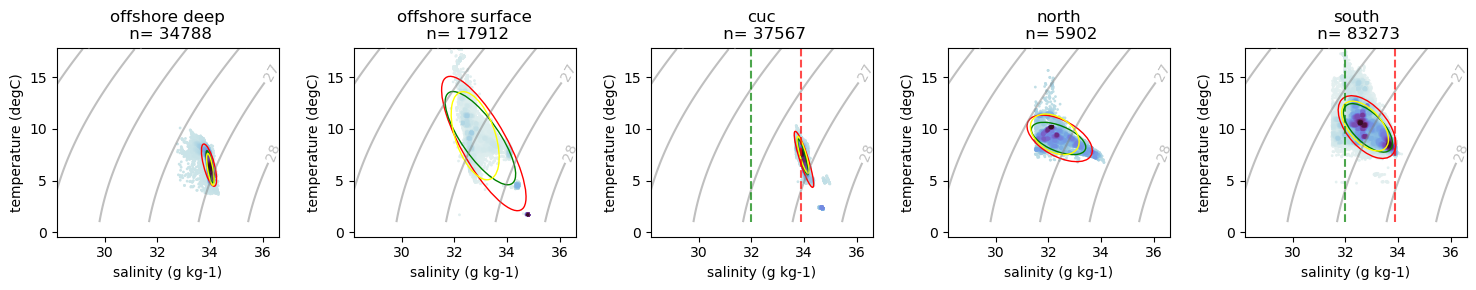

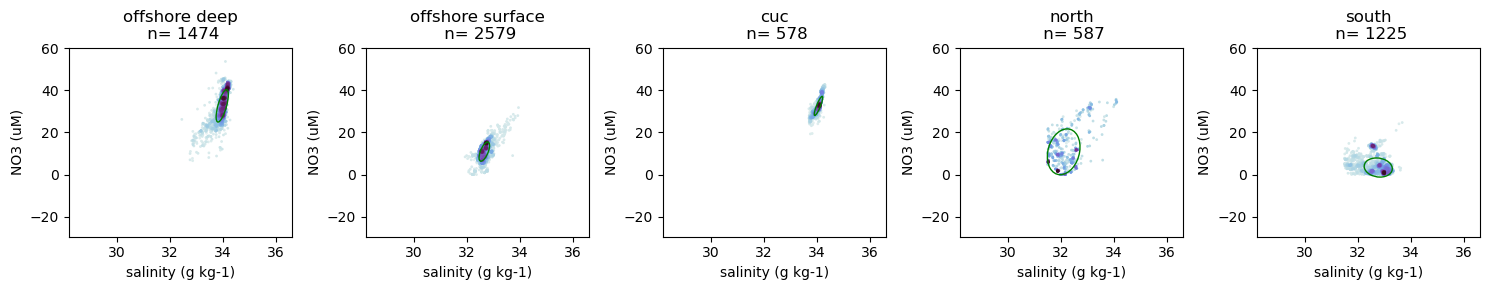

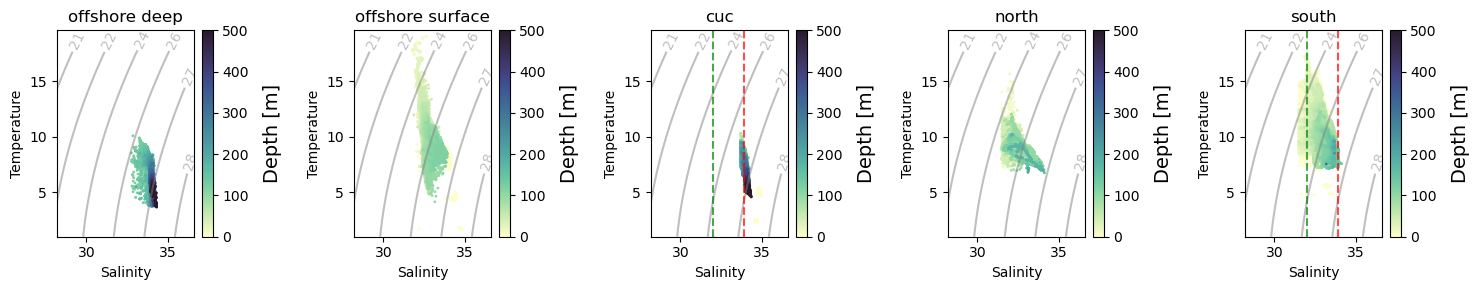

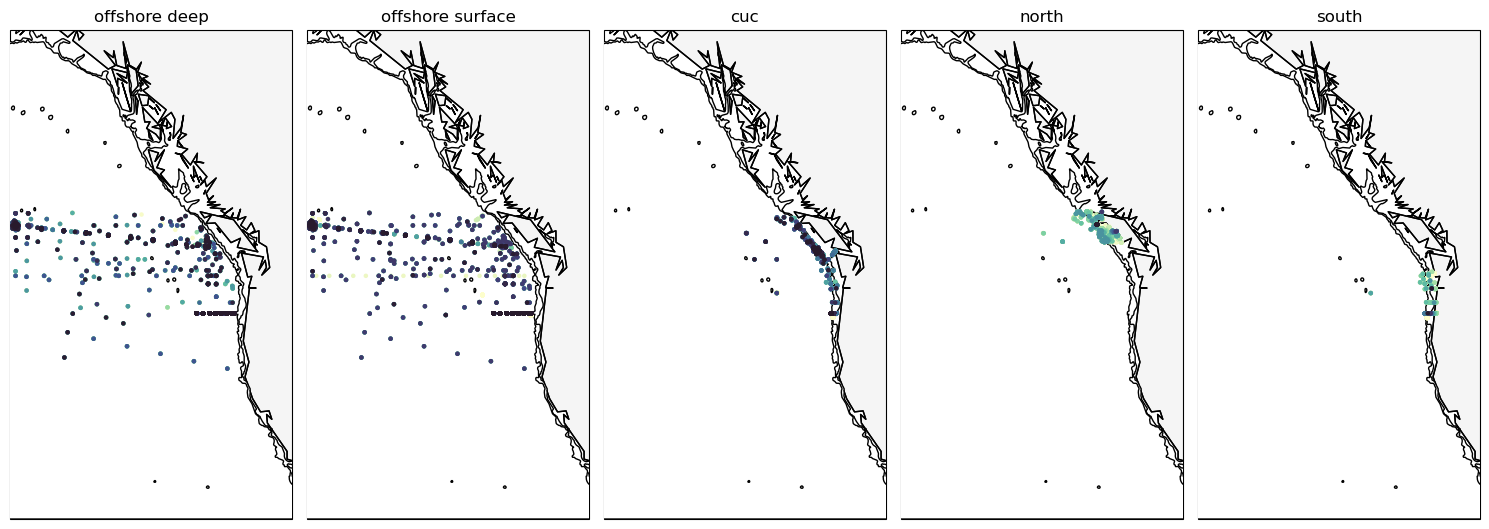

In [43]:
regions = ['offshore deep','offshore surface', 'cuc', 'north', 'south']

#elipse information
fig, ax = plt.subplots(1,len(regions),figsize=[len(regions)*3,3])
for i in range(len(ax)):
    TS(wob,regions[i],ax[i],'salinity (g kg-1)','temperature (degC)')
    confidence_ellipse(np.array(wob['salinity (g kg-1)'][wob.region == regions[i]]), np.array(wob['temperature (degC)'][wob.region == regions[i]]), ax[i], n_std=2, edgecolor='red')
    ell = percentile_ellipse(np.array(wob['salinity (g kg-1)'][wob.region == regions[i]]), np.array(wob['temperature (degC)'][wob.region == regions[i]]), ax[i], percentile=75, facecolor='none',edgecolor='green')
    ax[i].add_patch(ell)
    percentile_mode_ellipse(np.array(wob['salinity (g kg-1)'][wob.region == regions[i]]), np.array(wob['temperature (degC)'][wob.region == regions[i]]), ax[i], percentile=75,facecolor='none', edgecolor='yellow')


# show boundaries from CIOPS analysis
ax[2].plot([33.9,33.9],[tmin,tmax],'r--', alpha=0.7, label='Deep division')
ax[2].plot([32,32],[tmin,tmax],'g--',alpha=0.7,label='Columbia division')
ax[4].plot([33.9,33.9],[tmin,tmax],'r--', alpha=0.7, label='Deep division')
ax[4].plot([32,32],[tmin,tmax],'g--',alpha=0.7,label='Columbia division')
plt.tight_layout()

# Nitrate - Salinity
#elipse information
fig, ax = plt.subplots(1,len(regions),figsize=[len(regions)*3,3])
for i in range(len(ax)):
    TS(wob,regions[i],ax[i],'salinity (g kg-1)','NO3 (uM)')
    ell = percentile_ellipse(np.array(wob['salinity (g kg-1)'][wob.region == regions[i]]), np.array(wob['NO3 (uM)'][wob.region == regions[i]]), ax[i], percentile=50, facecolor='none', edgecolor='green')
    ax[i].add_patch(ell)
plt.tight_layout()

# TA - Salinity
#elipse information
# fig, ax = plt.subplots(1,len(regions),figsize=[len(regions)*3,3])
# for i in range(len(ax)):
#     TS(wob,regions[i],ax[i],'salinity (g kg-1)','TA (uM)')
#     ell = percentile_ellipse(np.array(wob['salinity (g kg-1)'][wob.region == regions[i]]), np.array(wob['TA (uM)'][wob.region == regions[i]]), ax[i], percentile=50, facecolor='none', edgecolor='green')
#     ax[i].add_patch(ell)
# plt.tight_layout()

# TS coloured by depth
fig, ax = plt.subplots(1,len(regions),figsize=[len(regions)*3,3])
for i in range(len(ax)):
    TS_depth(wob,regions[i],ax[i])

# show boundaries from CIOPS analysis
ax[2].plot([33.9,33.9],[tmin,tmax],'r--', alpha=0.7, label='Deep division')
ax[2].plot([32,32],[tmin,tmax],'g--',alpha=0.7,label='Columbia division')
ax[4].plot([33.9,33.9],[tmin,tmax],'r--', alpha=0.7, label='Deep division')
ax[4].plot([32,32],[tmin,tmax],'g--',alpha=0.7,label='Columbia division')
plt.tight_layout()

xlim, ylim = [-145.5, -120.2], [30, 60]
fig, ax = plt.subplots(1,5, figsize=(len(regions)*3,6), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})
for i in range(len(ax)):
    xy_depth(wob,regions[i],ax[i])
plt.tight_layout()

NOTE: my summer and winter CUC definition overlaps well with ~40% PEW line (Newport - Vancouver Island Shelf) in figure 1 of Thomson and Krassovski (2010) for water between around 150-300 m deep

### Boxplots

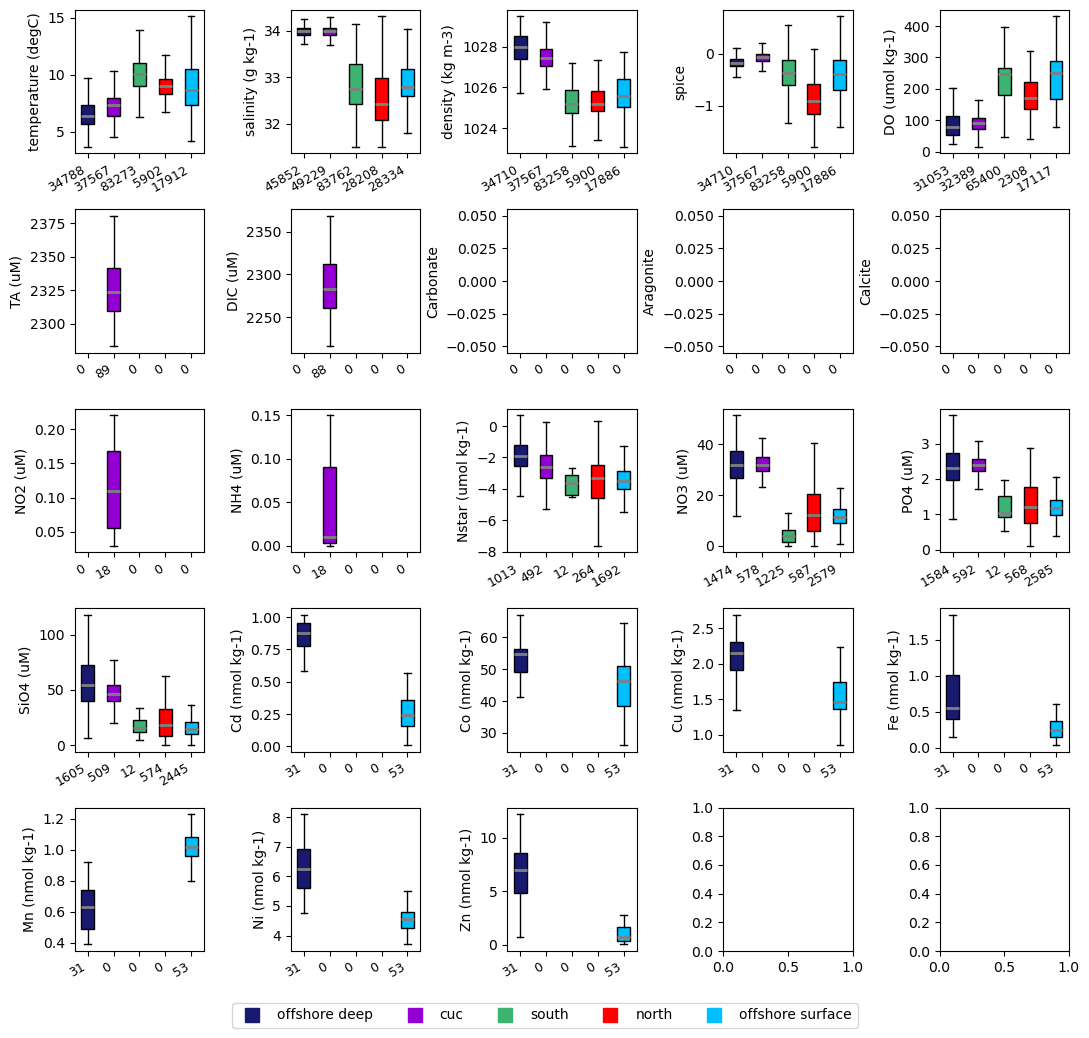

In [44]:
# box plots of different tracers
regions = ['offshore deep', 'cuc', 'south', 'north', 'offshore surface']
colour = ['midnightblue','darkviolet','mediumseagreen','red','deepskyblue']

fig, ax = plt.subplots(5,5,figsize=[11,10])

properties = ['temperature (degC)','salinity (g kg-1)','density (kg m-3)','spice','DO (umol kg-1)']
for i in range(len(properties)):
    bplot = box(wob,regions,properties[i],ax[0,i])
    for patch, color in zip(bplot['boxes'], colour):
        patch.set_facecolor(color)
    for median in bplot['medians']:
        median.set_color('grey')
        median.set_linewidth(2)

properties = ['TA (uM)','DIC (uM)','Carbonate','Aragonite', 'Calcite']
for i in range(len(properties)):
    bplot = box(wob,regions,properties[i],ax[1,i])
    for patch, color in zip(bplot['boxes'], colour):
        patch.set_facecolor(color)
    for median in bplot['medians']:
        median.set_color('grey')
        median.set_linewidth(2)

properties = ['NO2 (uM)','NH4 (uM)','Nstar (umol kg-1)','NO3 (uM)','PO4 (uM)']
for i in range(len(properties)):
    bplot = box(wob,regions,properties[i],ax[2,i])
    for patch, color in zip(bplot['boxes'], colour):
        patch.set_facecolor(color)
    for median in bplot['medians']:
        median.set_color('grey')
        median.set_linewidth(2)

# ## To indicate significance
# ax[1,0].plot([1, 1, 3, 3], [52, 54, 54, 49], linewidth=1, color='grey')
# ax[1,0].text(2, 47, "*", ha='center', va='bottom', color='grey',fontsize=10)
# ax[1,0].plot([4, 4, 5, 5], [0, -2, -2, 0], linewidth=1, color='grey')
# ax[1,0].text(4.5, -4, "*", ha='center', va='bottom', color='grey',fontsize=10)


properties = ['SiO4 (uM)', 'Cd (nmol kg-1)','Co (nmol kg-1)','Cu (nmol kg-1)','Fe (nmol kg-1)']
for i in range(len(properties)):
    bplot = box(wob,regions,properties[i],ax[3,i])
    for patch, color in zip(bplot['boxes'], colour):
        patch.set_facecolor(color)
    for median in bplot['medians']:
        median.set_color('grey')
        median.set_linewidth(2)

properties = ['Mn (nmol kg-1)','Ni (nmol kg-1)', 'Zn (nmol kg-1)']
for i in range(len(properties)):
    bplot = box(wob,regions,properties[i],ax[4,i])
    for patch, color in zip(bplot['boxes'], colour):
        patch.set_facecolor(color)
    for median in bplot['medians']:
        median.set_color('grey')
        median.set_linewidth(2)

# build legend handles    
legend_handles = []
for i in range(len(regions)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker='s', linestyle='None',markersize=10,
                          markeredgecolor=colour[i], markerfacecolor=colour[i],
                          label=regions[i]))
# Add a figure-wide legend below the subplots
fig.legend(handles=legend_handles, loc='upper center', ncol=5, bbox_to_anchor=(0.5, -0.001), frameon=True)

plt.tight_layout()
    


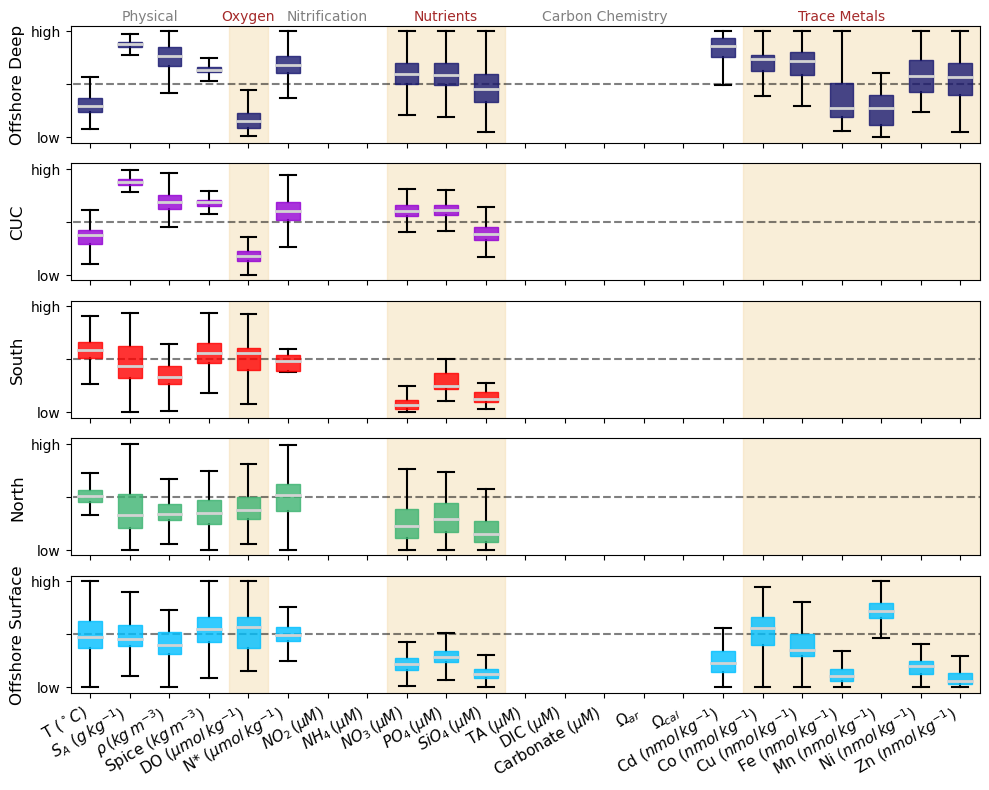

In [58]:
regions = ['offshore deep','cuc','south','north','offshore surface']
colour = ['midnightblue','darkviolet',  'r', 'mediumseagreen', 'deepskyblue']

data = wob
properties = ['temperature (degC)','salinity (g kg-1)','density (kg m-3)','spice','DO (umol kg-1)', 
              'Nstar (umol kg-1)','NO2 (uM)','NH4 (uM)','NO3 (uM)','PO4 (uM)','SiO4 (uM)', 'TA (uM)',
              'DIC (uM)','Carbonate','Aragonite', 'Calcite','Cd (nmol kg-1)','Co (nmol kg-1)',
              'Cu (nmol kg-1)','Fe (nmol kg-1)','Mn (nmol kg-1)','Ni (nmol kg-1)', 'Zn (nmol kg-1)']

# Function to calculate boxplot statistics
def calculate_boxplot_statistics(data, up, down,prop, region):
    region_data = data[data['region'] == region][prop].dropna()
    up_data = up[up['region'] == region][prop].dropna()
    down_data = down[down['region'] == region][prop].dropna()

    if len(region_data)>0:
        Q1 = np.percentile(region_data, 25)
        Q3 = np.percentile(region_data, 75)
        IQR = Q3 - Q1
        whisker_min = max(region_data.min(), Q1 - 1.5 * IQR)
        whisker_max = min(region_data.max(), Q3 + 1.5 * IQR)
        median = np.median(region_data)
        mean = np.mean(region_data)
        up_mean = np.mean(up_data)
        up_median = np.median(up_data)
        down_mean = np.mean(down_data)
        down_median = np.median(down_data)
    else:
        Q1 = np.nan
        Q3 = np.nan
        whisker_min = np.nan
        whisker_max = np.nan
        median = np.nan
        mean = np.nan
        up_mean = np.nan
        up_median = np.nan
        down_mean = np.nan
        down_median = np.nan
    return {
        'whisker_min': whisker_min,
        'Q1': Q1,
        'median': median,
        'mean': mean,
        'Q3': Q3,
        'whisker_max': whisker_max,
        'up_mean': up_mean,
        'up_median': up_median,
        'down_mean': down_mean,
        'down_median': down_median
    }

# Collect boxplot statistics for all regions and properties
boxplot_statistics = {prop: {region: calculate_boxplot_statistics(data, sob, wob, prop, region) for region in regions} for prop in properties}

# Normalize the statistics for plotting
normalized_statistics = {}
for prop in properties:
    # Gather all values to determine the global min and max for normalization
    all_values = []
    for region, statistics in boxplot_statistics[prop].items():
        all_values.extend([statistics['whisker_min'], statistics['Q1'], statistics['median'], statistics['mean'], statistics['Q3'], statistics['whisker_max'],
                            statistics['up_mean'], statistics['up_median'],statistics['down_mean'],statistics['down_median']])
    
    global_min = min(all_values)
    global_max = max(all_values)
    
    # Normalize all statistics using the same range
    normalized_statistics[prop] = {
        region: {
            key: (value - global_min) / (global_max - global_min)
            for key, value in statistics.items()
        }
        for region, statistics in boxplot_statistics[prop].items()
    }

# Plot normalized boxplots manually
fig, axes = plt.subplots(len(regions), 1, figsize=(10, 8), sharex=True)

for i, region in enumerate(regions):
    ax = axes[i]
    box_data = []
    for prop in properties:
        statistics = normalized_statistics[prop][region]
        box_data.append([
            statistics['whisker_min'], statistics['Q1'], statistics['median'], statistics['mean'], statistics['Q3'], statistics['whisker_max'],
            statistics['up_mean'], statistics['up_median'],statistics['down_mean'],statistics['down_median']
        ])
    
    # Manual construction of boxplot
    for j, statistics in enumerate(box_data):
        x = j + 1
        ax.plot([x, x], [statistics[0], statistics[1]], color='black',zorder=2)  # Lower whisker
        ax.plot([x, x], [statistics[4], statistics[5]], color='black',zorder=2)  # Upper whisker
        ax.plot([x - 0.2, x + 0.2], [statistics[0], statistics[0]], color='black',zorder=2)  # Lower cap
        ax.plot([x - 0.2, x + 0.2], [statistics[5], statistics[5]], color='black',zorder=2)  # Upper cap
        ax.add_patch(plt.Rectangle((x - 0.3, statistics[1]), 0.6, statistics[4] - statistics[1], color=colour[i], alpha=0.8,zorder=3))  # Box
        ax.plot([x - 0.3, x + 0.3], [statistics[2], statistics[2]], color='lightgrey', linewidth=2,zorder=4)  # Median
        # ax.plot([x - 0.3, x + 0.3], [statistics[3], statistics[3]], color='grey', ls='dotted', linewidth=2,zorder=4)  # Mean

    
    ax.set_xticks(range(1, len(properties) + 1))
    prop_name = ['T ($^\circ C$)','$S_A$ ($g\,kg^{-1}$)',r'$\rho \,(kg\,m^{-3})$','Spice $(kg\,m^{-3})$','DO ($\mu mol\,kg^{-1}$)', 
              'N* ($\mu mol\,kg^{-1}$)','$NO_2\,(\mu M)$','$NH_4\,(\mu M)$','$NO_3\,(\mu M)$', '$PO_4\,(\mu M)$', '$SiO_4\,(\mu M)$', 'TA $(\mu M)$',
              'DIC $(\mu M)$', 'Carbonate $(\mu M)$','$\Omega_{ar}$', '$\Omega_{cal}$','Cd ($nmol\,kg^{-1}$)','Co ($nmol\,kg^{-1}$)',
              'Cu ($nmol\,kg^{-1}$)','Fe ($nmol\,kg^{-1}$)','Mn ($nmol\,kg^{-1}$)','Ni ($nmol\,kg^{-1}$)', 'Zn ($nmol\,kg^{-1}$)']
    ax.set_xticklabels(prop_name,rotation=30,ha='right',fontsize=11)
    ax.set_yticks([0,0.5,1])
    ax.set_yticklabels(['low',' ','high'])

    ax.set_xlim([0.5,len(properties)+0.5])
    ax.set_ylim([-0.05,1.05])
    ax.plot([0,len(properties)+1],[0.5,0.5],'k--',zorder=1,alpha=0.5)

    # tracer categories
    # ax.fill_between(np.arange(0,len(properties)+1,0.5), -0.1, 1.1, where=(np.arange(0,len(properties)+1,0.5)<=4.5)&(np.arange(0,len(properties)+1,0.5)>=0), color='wheat', alpha=0.5, zorder=0)
    # ax.fill_between(np.arange(0,len(properties)+1,0.5), -0.1, 1.1, where=(np.arange(0,len(properties)+1,0.5)<=8.5)&(np.arange(0,len(properties)+1,0.5)>=5.5), color='wheat', alpha=0.5, zorder=0)
    # ax.fill_between(np.arange(0,len(properties)+1,0.5), -0.1, 1.1, where=(np.arange(0,len(properties)+1,0.5)<=18)&(np.arange(0,len(properties)+1,0.5)>=11.5), color='wheat', alpha=0.5, zorder=0)
    ax.fill_between(np.arange(0,len(properties)+1,0.5), -0.1, 1.1, where=(np.arange(0,len(properties)+1,0.5)<=5.5)&(np.arange(0,len(properties)+1,0.5)>=4.5), color='wheat', alpha=0.5, zorder=0)
    ax.fill_between(np.arange(0,len(properties)+1,0.5), -0.1, 1.1, where=(np.arange(0,len(properties)+1,0.5)<=11.5)&(np.arange(0,len(properties)+1,0.5)>=8.5), color='wheat', alpha=0.5, zorder=0)
    ax.fill_between(np.arange(0,len(properties)+1,0.5), -0.1, 1.1, where=(np.arange(0,len(properties)+1,0.5)<=25.5)&(np.arange(0,len(properties)+1,0.5)>=17.5), color='wheat', alpha=0.5, zorder=0)



# region labels
axes[0].set_ylabel('Offshore Deep',fontsize=12)
axes[1].set_ylabel('CUC',fontsize=12)
axes[2].set_ylabel('South',fontsize=12)
axes[3].set_ylabel('North',fontsize=12)
axes[4].set_ylabel('Offshore Surface',fontsize=12)

# text above the top plot to label tracer categories
axes[0].text(2.5, 1.1, "Physical", ha='center', color='grey', fontsize=10)
axes[0].text(5, 1.1, "Oxygen", ha='center', color='brown', fontsize=10)
axes[0].text(7, 1.1, "Nitrification", ha='center', color='grey', fontsize=10)
axes[0].text(10, 1.1, "Nutrients", ha='center', color='brown', fontsize=10)
axes[0].text(14, 1.1, "Carbon Chemistry", ha='center', color='grey', fontsize=10)
axes[0].text(20, 1.1, "Trace Metals", ha='center', color='brown', fontsize=10)


plt.tight_layout()

### Statistics

In [46]:
properties = ['temperature (degC)','salinity (g kg-1)','density (kg m-3)','spice','DO (umol kg-1)', 
              'Nstar (umol kg-1)','NO3 (uM)','NO2 (uM)','NH4 (uM)', 'PO4 (uM)', 'SiO4 (uM)', 'TA (uM)',
              'DIC (uM)', 'Carbonate','Aragonite', 'Calcite']

alpha = 0.05

for prop in properties:
    print(prop)
    # Filter out NaN values and exclude 'none' and 'brackish' regions
    obs_filtered = wob.dropna(subset=[prop])
    obs_filtered = obs_filtered[~obs_filtered['region'].isin(['none', 'brackish'])]

    # Perform one-way ANOVA
    groups = [obs_filtered[obs_filtered['region'] == region][prop] for region in ['cuc', 'offshore deep', 'offshore surface', 'south', 'north']]
    anova_result = stats.f_oneway(*groups)

    # Output ANOVA result
    if anova_result.pvalue < alpha:
        print(f"Significant differences found between regions (p = {anova_result.pvalue:.4f}) at α = {alpha}.\n")
        
        # Perform Tukey HSD test for post hoc analysis
        tukey_result = pairwise_tukeyhsd(endog=obs_filtered[prop], groups=obs_filtered['region'], alpha=alpha)
        
        # Extract Tukey results into a DataFrame
        tukey_df = pd.DataFrame(data=tukey_result._results_table.data[1:], columns=tukey_result._results_table.data[0])
        
        # Calculate Cohen's d and OVL for each pair of regions
        additional_results = []
        for i, row in tukey_df.iterrows():
            region1, region2 = row['group1'], row['group2']
            data1 = obs_filtered[obs_filtered['region'] == region1][prop]
            data2 = obs_filtered[obs_filtered['region'] == region2][prop]
            
            # Cohen's d calculation
            mean_diff = np.mean(data1) - np.mean(data2)
            pooled_std = np.sqrt((np.var(data1, ddof=1) + np.var(data2, ddof=1)) / 2)
            cohens_d = mean_diff / pooled_std if pooled_std != 0 else np.nan
            
            # Overlap Coefficient (OVL) calculation
            overlap_coef = 2 * stats.norm.cdf(-abs(cohens_d) / 2) if not np.isnan(cohens_d) else np.nan
            
            additional_results.append((cohens_d, overlap_coef))
        
        # Add Cohen's d and OVL to the DataFrame
        tukey_df[['Cohen\'s d', 'OVL']] = additional_results
        print("Tukey HSD post hoc results with Cohen's d and OVL:")
        print(tukey_df)
    else:
        print(f"No significant differences between regions (p = {anova_result.pvalue:.8f}) at α = {alpha}.")
    print('\n')



temperature (degC)
Significant differences found between regions (p = 0.0000) at α = 0.05.

Tukey HSD post hoc results with Cohen's d and OVL:
             group1            group2  meandiff  p-adj   lower   upper  \
0               cuc             north    2.0257    0.0  1.9624  2.0890   
1               cuc     offshore deep   -0.5577    0.0 -0.5913 -0.5241   
2               cuc  offshore surface    1.5267    0.0  1.4857  1.5677   
3               cuc             south    3.1177    0.0  3.0896  3.1458   
4             north     offshore deep   -2.5834    0.0 -2.6470 -2.5198   
5             north  offshore surface   -0.4990    0.0 -0.5668 -0.4312   
6             north             south    1.0920    0.0  1.0311  1.1528   
7     offshore deep  offshore surface    2.0844    0.0  2.0428  2.1259   
8     offshore deep             south    3.6754    0.0  3.6465  3.7042   
9  offshore surface             south    1.5910    0.0  1.5538  1.6282   

   reject  Cohen's d       OVL  
0    True

In [47]:
all_prop= ['temperature (degC)', 'salinity (g kg-1)', 'DO (umol kg-1)', 'NO3 (uM)',
       'NO2 (uM)', 'NH4 (uM)', 'PO4 (uM)', 'SiO4 (uM)', 'Chl (mg m-3)',
       'TA (uM)', 'DIC (uM)', 'Carbonate', 'Aragonite', 'Calcite',
       'Cd (nmol kg-1)', 'Co (nmol kg-1)', 'Cu (nmol kg-1)', 'Fe (nmol kg-1)',
       'Mn (nmol kg-1)', 'Ni (nmol kg-1)', 'Zn (nmol kg-1)','Nstar (umol kg-1)', 
       'spice', 'density (kg m-3)']

for prop in all_prop:
    print(prop)
    for r in regions:
        print('{} mean = {}, std = {}'.format(r,np.nanmean(wob[prop][(wob.region == r)]),np.nanstd(wob[prop][(wob.region == r)])))
    print("\n")

temperature (degC)
offshore deep mean = 6.509926887397393, std = 1.021501709169804
cuc mean = 7.0676087084401695, std = 1.3530888559873482
south mean = 10.185299375144195, std = 1.5151727327378852
north mean = 9.093307444156258, std = 1.1247763094908325
offshore surface mean = 8.594282828892826, std = 3.2433220512560212


salinity (g kg-1)
offshore deep mean = 33.952154160588194, std = 0.1795901045354979
cuc mean = 34.00742723265203, std = 0.17936125098944075
south mean = 32.82174055672086, std = 0.5454372732151322
north mean = 32.573948971099945, std = 0.6666271218749283
offshore surface mean = 33.00265632761317, std = 0.6692285820140936


DO (umol kg-1)
offshore deep mean = 86.93245771616095, std = 42.72046913519669
cuc mean = 90.49585412306462, std = 36.49333756309557
south mean = 224.50377806240294, std = 60.982378092389254
north mean = 176.77241180908442, std = 54.48488875878568
offshore surface mean = 230.7422909872484, std = 75.04652693095251


NO3 (uM)
offshore deep mean = 31.5

In [48]:
all_prop= ['temperature (degC)', 'salinity (g kg-1)', 'density (kg m-3)', 'spice', 'DO (umol kg-1)','Nstar (umol kg-1)',
       'NO2 (uM)', 'NH4 (uM)', 'NO3 (uM)', 'PO4 (uM)', 'SiO4 (uM)', 'Chl (mg m-3)',
       'TA (uM)', 'DIC (uM)', 'Carbonate', 'Aragonite', 'Calcite',
       'Cd (nmol kg-1)', 'Co (nmol kg-1)', 'Cu (nmol kg-1)', 'Fe (nmol kg-1)',
       'Mn (nmol kg-1)', 'Ni (nmol kg-1)', 'Zn (nmol kg-1)']

print(regions)
for prop in all_prop:
    # print in the same format as a latex table
    print('{} &{} ({}) &{} ({}) &{} ({}) &{} ({}) &{} ({}) \\'.format(prop,
                np.round(np.nanmean(wob[prop][(wob.region == regions[0])]),1),np.round(np.nanstd(wob[prop][(wob.region == regions[0])]),1),
                np.round(np.nanmean(wob[prop][(wob.region == regions[1])]),1),np.round(np.nanstd(wob[prop][(wob.region == regions[1])]),1),
                np.round(np.nanmean(wob[prop][(wob.region == regions[2])]),1),np.round(np.nanstd(wob[prop][(wob.region == regions[2])]),1),
                np.round(np.nanmean(wob[prop][(wob.region == regions[3])]),1),np.round(np.nanstd(wob[prop][(wob.region == regions[3])]),1),
                np.round(np.nanmean(wob[prop][(wob.region == regions[4])]),1),np.round(np.nanstd(wob[prop][(wob.region == regions[4])]),1)))
    # print("\n")

['offshore deep', 'cuc', 'south', 'north', 'offshore surface']
temperature (degC) &6.5 (1.0) &7.1 (1.4) &10.2 (1.5) &9.1 (1.1) &8.6 (3.2) \
salinity (g kg-1) &34.0 (0.2) &34.0 (0.2) &32.8 (0.5) &32.6 (0.7) &33.0 (0.7) \
density (kg m-3) &1027.9 (0.7) &1027.5 (0.7) &1025.3 (0.7) &1025.3 (0.7) &1025.7 (1.0) \
spice &-0.2 (0.1) &-0.1 (0.1) &-0.4 (0.3) &-0.9 (0.4) &-0.4 (0.4) \
DO (umol kg-1) &86.9 (42.7) &90.5 (36.5) &224.5 (61.0) &176.8 (54.5) &230.7 (75.0) \
Nstar (umol kg-1) &-1.8 (1.2) &-2.6 (1.5) &-3.7 (0.7) &-3.8 (2.7) &-3.4 (1.0) \
NO2 (uM) &nan (nan) &0.1 (0.1) &nan (nan) &nan (nan) &nan (nan) \
NH4 (uM) &nan (nan) &0.2 (0.6) &nan (nan) &nan (nan) &nan (nan) \
NO3 (uM) &31.6 (7.4) &32.5 (4.1) &4.7 (4.1) &13.9 (9.9) &11.6 (4.3) \
PO4 (uM) &2.3 (0.5) &2.4 (0.3) &1.2 (0.5) &1.3 (0.6) &1.2 (0.3) \
SiO4 (uM) &56.4 (21.5) &48.2 (12.6) &16.7 (8.9) &21.2 (14.8) &16.0 (7.5) \
Chl (mg m-3) &0.1 (0.1) &0.0 (0.0) &1.4 (1.9) &1.5 (1.8) &0.7 (0.6) \
TA (uM) &nan (nan) &2326.4 (20.9) &nan (nan) 

# winter summer compare

In [49]:
# add [TA-DIC] 
sob['[TA-DIC]'] = sob['TA (uM)'] - sob['DIC (uM)']
wob['[TA-DIC]'] = wob['TA (uM)'] - wob['DIC (uM)']
obs['[TA-DIC]'] = obs['TA (uM)'] - obs['DIC (uM)']


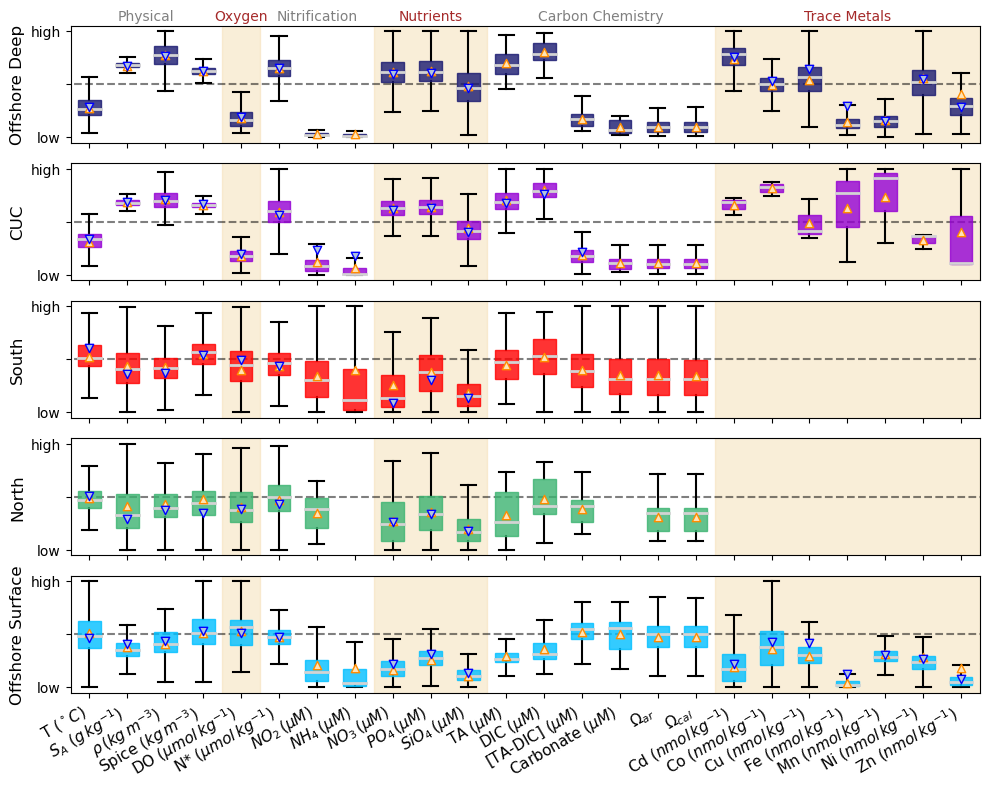

In [61]:
regions = ['offshore deep','cuc','south','north','offshore surface']
colour = ['midnightblue','darkviolet',  'r', 'mediumseagreen', 'deepskyblue']

data = obs
properties = ['temperature (degC)','salinity (g kg-1)','density (kg m-3)','spice','DO (umol kg-1)', 
              'Nstar (umol kg-1)','NO2 (uM)','NH4 (uM)','NO3 (uM)','PO4 (uM)','SiO4 (uM)', 'TA (uM)',
              'DIC (uM)','[TA-DIC]', 'Carbonate','Aragonite', 'Calcite','Cd (nmol kg-1)','Co (nmol kg-1)',
              'Cu (nmol kg-1)','Fe (nmol kg-1)','Mn (nmol kg-1)','Ni (nmol kg-1)', 'Zn (nmol kg-1)']

# Function to calculate boxplot statistics
def calculate_boxplot_statistics(data, up, down,prop, region):
    region_data = data[data['region'] == region][prop].dropna()
    up_data = up[up['region'] == region][prop].dropna()
    down_data = down[down['region'] == region][prop].dropna()

    if len(region_data)>0:
        Q1 = np.percentile(region_data, 25)
        Q3 = np.percentile(region_data, 75)
        IQR = Q3 - Q1
        whisker_min = max(region_data.min(), Q1 - 1.5 * IQR)
        whisker_max = min(region_data.max(), Q3 + 1.5 * IQR)
        median = np.median(region_data)
        mean = np.mean(region_data)
        up_mean = np.mean(up_data)
        up_median = np.median(up_data)
        down_mean = np.mean(down_data)
        down_median = np.median(down_data)
    else:
        Q1 = np.nan
        Q3 = np.nan
        whisker_min = np.nan
        whisker_max = np.nan
        median = np.nan
        mean = np.nan
        up_mean = np.nan
        up_median = np.nan
        down_mean = np.nan
        down_median = np.nan
    return {
        'whisker_min': whisker_min,
        'Q1': Q1,
        'median': median,
        'mean': mean,
        'Q3': Q3,
        'whisker_max': whisker_max,
        'up_mean': up_mean,
        'up_median': up_median,
        'down_mean': down_mean,
        'down_median': down_median
    }

# Collect boxplot statistics for all regions and properties
boxplot_statistics = {prop: {region: calculate_boxplot_statistics(data, sob, wob, prop, region) for region in regions} for prop in properties}

# Normalize the statistics for plotting
normalized_statistics = {}
for prop in properties:
    # Gather all values to determine the global min and max for normalization
    all_values = []
    for region, statistics in boxplot_statistics[prop].items():
        all_values.extend([statistics['whisker_min'], statistics['Q1'], statistics['median'], statistics['mean'], statistics['Q3'], statistics['whisker_max'],
                            statistics['up_mean'], statistics['up_median'],statistics['down_mean'],statistics['down_median']])
    
    global_min = min(all_values)
    global_max = max(all_values)
    
    # Normalize all statistics using the same range
    normalized_statistics[prop] = {
        region: {
            key: (value - global_min) / (global_max - global_min)
            for key, value in statistics.items()
        }
        for region, statistics in boxplot_statistics[prop].items()
    }

# Plot normalized boxplots manually
fig, axes = plt.subplots(len(regions), 1, figsize=(10, 8), sharex=True)

for i, region in enumerate(regions):
    ax = axes[i]
    box_data = []
    for prop in properties:
        statistics = normalized_statistics[prop][region]
        box_data.append([
            statistics['whisker_min'], statistics['Q1'], statistics['median'], statistics['mean'], statistics['Q3'], statistics['whisker_max'],
            statistics['up_mean'], statistics['up_median'],statistics['down_mean'],statistics['down_median']
        ])
    
    # Manual construction of boxplot
    for j, statistics in enumerate(box_data):
        x = j + 1
        ax.plot([x, x], [statistics[0], statistics[1]], color='black',zorder=2)  # Lower whisker
        ax.plot([x, x], [statistics[4], statistics[5]], color='black',zorder=2)  # Upper whisker
        ax.plot([x - 0.2, x + 0.2], [statistics[0], statistics[0]], color='black',zorder=2)  # Lower cap
        ax.plot([x - 0.2, x + 0.2], [statistics[5], statistics[5]], color='black',zorder=2)  # Upper cap
        ax.add_patch(plt.Rectangle((x - 0.3, statistics[1]), 0.6, statistics[4] - statistics[1], color=colour[i], alpha=0.8,zorder=3))  # Box
        ax.plot([x - 0.3, x + 0.3], [statistics[2], statistics[2]], color='lightgrey', linewidth=2,zorder=4)  # Median
        # ax.plot([x - 0.3, x + 0.3], [statistics[3], statistics[3]], color='grey', ls='dotted', linewidth=2,zorder=4)  # Mean
        ax.scatter(x, statistics[6], marker='^',c='moccasin',edgecolors='darkorange',zorder=4)  # upwelling mean
        ax.scatter(x, statistics[8], marker='v',c='lightsteelblue',edgecolors='blue',zorder=4)  # downwelling mean
        # ax.plot(x, statistics[7], marker='*',color='orange', zorder=4)  # upwelling median
        # ax.plot(x, statistics[9], marker='*',color='blue', zorder=4)  # downwelling median

    
    ax.set_xticks(range(1, len(properties) + 1))
    prop_name = ['T ($^\circ C$)','$S_A$ ($g\,kg^{-1}$)',r'$\rho \,(kg\,m^{-3})$','Spice $(kg\,m^{-3})$','DO ($\mu mol\,kg^{-1}$)', 
              'N* ($\mu mol\,kg^{-1}$)','$NO_2\,(\mu M)$','$NH_4\,(\mu M)$','$NO_3\,(\mu M)$', '$PO_4\,(\mu M)$', '$SiO_4\,(\mu M)$', 'TA $(\mu M)$',
              'DIC $(\mu M)$', '[TA-DIC] $(\mu M)$', 'Carbonate $(\mu M)$','$\Omega_{ar}$', '$\Omega_{cal}$','Cd ($nmol\,kg^{-1}$)','Co ($nmol\,kg^{-1}$)',
              'Cu ($nmol\,kg^{-1}$)','Fe ($nmol\,kg^{-1}$)','Mn ($nmol\,kg^{-1}$)','Ni ($nmol\,kg^{-1}$)', 'Zn ($nmol\,kg^{-1}$)']
    ax.set_xticklabels(prop_name,rotation=30,ha='right',fontsize=11)
    ax.set_yticks([0,0.5,1])
    ax.set_yticklabels(['low',' ','high'])

    ax.set_xlim([0.5,len(properties)+0.5])
    ax.set_ylim([-0.05,1.05])
    ax.plot([0,len(properties)+1],[0.5,0.5],'k--',zorder=1,alpha=0.5)

    # tracer categories
    # ax.fill_between(np.arange(0,len(properties)+1,0.5), -0.1, 1.1, where=(np.arange(0,len(properties)+1,0.5)<=4.5)&(np.arange(0,len(properties)+1,0.5)>=0), color='wheat', alpha=0.5, zorder=0)
    # ax.fill_between(np.arange(0,len(properties)+1,0.5), -0.1, 1.1, where=(np.arange(0,len(properties)+1,0.5)<=8.5)&(np.arange(0,len(properties)+1,0.5)>=5.5), color='wheat', alpha=0.5, zorder=0)
    # ax.fill_between(np.arange(0,len(properties)+1,0.5), -0.1, 1.1, where=(np.arange(0,len(properties)+1,0.5)<=18)&(np.arange(0,len(properties)+1,0.5)>=11.5), color='wheat', alpha=0.5, zorder=0)
    ax.fill_between(np.arange(0,len(properties)+1,0.5), -0.1, 1.1, where=(np.arange(0,len(properties)+1,0.5)<=5.5)&(np.arange(0,len(properties)+1,0.5)>=4.5), color='wheat', alpha=0.5, zorder=0)
    ax.fill_between(np.arange(0,len(properties)+1,0.5), -0.1, 1.1, where=(np.arange(0,len(properties)+1,0.5)<=11.5)&(np.arange(0,len(properties)+1,0.5)>=8.5), color='wheat', alpha=0.5, zorder=0)
    ax.fill_between(np.arange(0,len(properties)+1,0.5), -0.1, 1.1, where=(np.arange(0,len(properties)+1,0.5)<=25.5)&(np.arange(0,len(properties)+1,0.5)>=17.5), color='wheat', alpha=0.5, zorder=0)



# region labels
axes[0].set_ylabel('Offshore Deep',fontsize=12)
axes[1].set_ylabel('CUC',fontsize=12)
axes[2].set_ylabel('South',fontsize=12)
axes[3].set_ylabel('North',fontsize=12)
axes[4].set_ylabel('Offshore Surface',fontsize=12)

# text above the top plot to label tracer categories
axes[0].text(2.5, 1.1, "Physical", ha='center', color='grey', fontsize=10)
axes[0].text(5, 1.1, "Oxygen", ha='center', color='brown', fontsize=10)
axes[0].text(7, 1.1, "Nitrification", ha='center', color='grey', fontsize=10)
axes[0].text(10, 1.1, "Nutrients", ha='center', color='brown', fontsize=10)
axes[0].text(14.5, 1.1, "Carbon Chemistry", ha='center', color='grey', fontsize=10)
axes[0].text(21, 1.1, "Trace Metals", ha='center', color='brown', fontsize=10)


plt.tight_layout()
plt.savefig('box.pdf')
plt.show()

In [51]:
all_prop= ['temperature (degC)', 'salinity (g kg-1)', 'density (kg m-3)', 'spice', 'DO (umol kg-1)','Nstar (umol kg-1)',
       'NO2 (uM)', 'NH4 (uM)', 'NO3 (uM)', 'PO4 (uM)', 'SiO4 (uM)', 'Chl (mg m-3)',
       'TA (uM)', 'DIC (uM)', '[TA-DIC]', 'Carbonate', 'Aragonite', 'Calcite',
       'Cd (nmol kg-1)', 'Co (nmol kg-1)', 'Cu (nmol kg-1)', 'Fe (nmol kg-1)',
       'Mn (nmol kg-1)', 'Ni (nmol kg-1)', 'Zn (nmol kg-1)']

print(regions)
for prop in all_prop:
    # print in the same format as a latex table
    print('{} &{} ({}) &{} ({}) &{} ({}) &{} ({}) &{} ({}) \\'.format(prop,
                np.round(np.nanmean(obs[prop][(obs.region == regions[0])]),1),np.round(np.nanstd(obs[prop][(obs.region == regions[0])]),1),
                np.round(np.nanmean(obs[prop][(obs.region == regions[1])]),1),np.round(np.nanstd(obs[prop][(obs.region == regions[1])]),1),
                np.round(np.nanmean(obs[prop][(obs.region == regions[2])]),1),np.round(np.nanstd(obs[prop][(obs.region == regions[2])]),1),
                np.round(np.nanmean(obs[prop][(obs.region == regions[3])]),1),np.round(np.nanstd(obs[prop][(obs.region == regions[3])]),1),
                np.round(np.nanmean(obs[prop][(obs.region == regions[4])]),1),np.round(np.nanstd(obs[prop][(obs.region == regions[4])]),1)))
    # print("\n")

['offshore deep', 'cuc', 'south', 'north', 'offshore surface']
temperature (degC) &6.4 (1.1) &6.9 (1.2) &9.6 (1.8) &8.9 (1.7) &8.9 (3.2) \
salinity (g kg-1) &34.0 (0.2) &34.0 (0.2) &33.0 (0.6) &32.8 (0.7) &32.9 (0.6) \
density (kg m-3) &1028.0 (0.7) &1027.6 (0.7) &1025.5 (0.8) &1025.5 (0.9) &1025.6 (1.0) \
spice &-0.2 (0.1) &-0.1 (0.1) &-0.4 (0.3) &-0.7 (0.4) &-0.4 (0.4) \
DO (umol kg-1) &84.0 (41.3) &82.9 (33.3) &197.7 (78.2) &180.7 (76.4) &236.7 (72.2) \
Nstar (umol kg-1) &-1.8 (1.4) &-2.4 (2.2) &-3.8 (2.0) &-3.5 (2.6) &-3.4 (1.3) \
NO2 (uM) &0.0 (0.0) &0.1 (0.1) &0.2 (0.1) &0.2 (0.1) &0.1 (0.1) \
NH4 (uM) &0.0 (0.1) &0.1 (0.2) &0.4 (0.8) &nan (nan) &0.2 (0.4) \
NO3 (uM) &32.3 (6.9) &33.4 (5.3) &11.0 (10.4) &14.5 (11.0) &9.5 (5.9) \
PO4 (uM) &2.4 (0.5) &2.4 (0.4) &1.4 (0.8) &1.3 (0.7) &1.0 (0.4) \
SiO4 (uM) &57.8 (21.0) &52.7 (15.8) &21.6 (16.7) &23.5 (16.0) &14.2 (8.6) \
Chl (mg m-3) &0.1 (0.2) &0.0 (0.1) &2.6 (3.2) &3.2 (4.3) &0.8 (2.3) \
TA (uM) &2331.6 (26.5) &2331.2 (23.6) &2274

In [52]:
properties = ['temperature (degC)','salinity (g kg-1)','density (kg m-3)','spice','DO (umol kg-1)', 
              'Nstar (umol kg-1)','NO3 (uM)','NO2 (uM)','NH4 (uM)', 'PO4 (uM)', 'SiO4 (uM)', 'TA (uM)',
              'DIC (uM)', '[TA-DIC]','Carbonate','Aragonite', 'Calcite']

alpha = 0.05

for prop in properties:
    print(prop)
    # Filter out NaN values and exclude 'none' and 'brackish' regions
    obs_filtered = obs.dropna(subset=[prop])
    obs_filtered = obs_filtered[~obs_filtered['region'].isin(['none', 'brackish'])]

    # Perform one-way ANOVA
    groups = [obs_filtered[obs_filtered['region'] == region][prop] for region in ['cuc', 'offshore deep', 'offshore surface', 'south', 'north']]
    anova_result = stats.f_oneway(*groups)

    # Output ANOVA result
    if anova_result.pvalue < alpha:
        print(f"Significant differences found between regions (p = {anova_result.pvalue:.4f}) at α = {alpha}.\n")
        
        # Perform Tukey HSD test for post hoc analysis
        tukey_result = pairwise_tukeyhsd(endog=obs_filtered[prop], groups=obs_filtered['region'], alpha=alpha)
        
        # Extract Tukey results into a DataFrame
        tukey_df = pd.DataFrame(data=tukey_result._results_table.data[1:], columns=tukey_result._results_table.data[0]).drop(['p-adj','lower','upper'],axis=1)
        
        # Calculate Cohen's d and OVL for each pair of regions
        additional_results = []
        for i, row in tukey_df.iterrows():
            region1, region2 = row['group1'], row['group2']
            data1 = obs_filtered[obs_filtered['region'] == region1][prop]
            data2 = obs_filtered[obs_filtered['region'] == region2][prop]
            
            # Cohen's d calculation
            mean_diff = np.mean(data1) - np.mean(data2)
            pooled_std = np.sqrt((np.var(data1, ddof=1) + np.var(data2, ddof=1)) / 2)
            cohens_d = mean_diff / pooled_std if pooled_std != 0 else np.nan
            
            # Overlap Coefficient (OVL) calculation
            overlap_coef = 2 * stats.norm.cdf(-abs(cohens_d) / 2) if not np.isnan(cohens_d) else np.nan
            
            additional_results.append((cohens_d, overlap_coef))
        
        # Add Cohen's d and OVL to the DataFrame
        tukey_df[['Cohen\'s d', 'OVL']] = additional_results
        print("Tukey HSD post hoc results with Cohen's d and OVL:")
        print(tukey_df)
    else:
        print(f"No significant differences between regions (p = {anova_result.pvalue:.8f}) at α = {alpha}.")
    print('\n')

temperature (degC)
Significant differences found between regions (p = 0.0000) at α = 0.05.

Tukey HSD post hoc results with Cohen's d and OVL:
             group1            group2  meandiff  reject  Cohen's d       OVL
0               cuc             north    2.0803    True  -1.422011  0.477081
1               cuc     offshore deep   -0.4823    True   0.416275  0.835122
2               cuc  offshore surface    2.0164    True  -0.841691  0.673868
3               cuc             south    2.7081    True  -1.770174  0.376110
4             north     offshore deep   -2.5626    True   1.813152  0.364631
5             north  offshore surface   -0.0639    True   0.025273  0.989918
6             north             south    0.6278    True  -0.362705  0.856091
7     offshore deep  offshore surface    2.4987    True  -1.056215  0.597425
8     offshore deep             south    3.1903    True  -2.152047  0.281917
9  offshore surface             south    0.6917    True  -0.269345  0.892871


salinity

In [62]:
properties = ['NH4 (uM)', 'Carbonate',]

alpha = 0.05

for prop in properties:
    print(prop)
    # Filter out NaN values and exclude 'none' and 'brackish' regions
    obs_filtered = obs.dropna(subset=[prop])
    obs_filtered = obs_filtered[~obs_filtered['region'].isin(['none', 'brackish'])]

    # Perform one-way ANOVA
    groups = [obs_filtered[obs_filtered['region'] == region][prop] for region in ['cuc', 'offshore deep', 'offshore surface', 'south']]
    anova_result = stats.f_oneway(*groups)

    # Output ANOVA result
    if anova_result.pvalue < alpha:
        print(f"Significant differences found between regions (p = {anova_result.pvalue:.4f}) at α = {alpha}.\n")
        
        # Perform Tukey HSD test for post hoc analysis
        tukey_result = pairwise_tukeyhsd(endog=obs_filtered[prop], groups=obs_filtered['region'], alpha=alpha)
        
        # Extract Tukey results into a DataFrame
        tukey_df = pd.DataFrame(data=tukey_result._results_table.data[1:], columns=tukey_result._results_table.data[0]).drop(['p-adj','lower','upper'],axis=1)
        
        # Calculate Cohen's d and OVL for each pair of regions
        additional_results = []
        for i, row in tukey_df.iterrows():
            region1, region2 = row['group1'], row['group2']
            data1 = obs_filtered[obs_filtered['region'] == region1][prop]
            data2 = obs_filtered[obs_filtered['region'] == region2][prop]
            
            # Cohen's d calculation
            mean_diff = np.mean(data1) - np.mean(data2)
            pooled_std = np.sqrt((np.var(data1, ddof=1) + np.var(data2, ddof=1)) / 2)
            cohens_d = mean_diff / pooled_std if pooled_std != 0 else np.nan
            
            # Overlap Coefficient (OVL) calculation
            overlap_coef = 2 * stats.norm.cdf(-abs(cohens_d) / 2) if not np.isnan(cohens_d) else np.nan
            
            additional_results.append((cohens_d, overlap_coef))
        
        # Add Cohen's d and OVL to the DataFrame
        tukey_df[['Cohen\'s d', 'OVL']] = additional_results
        print("Tukey HSD post hoc results with Cohen's d and OVL:")
        print(tukey_df)
    else:
        print(f"No significant differences between regions (p = {anova_result.pvalue:.8f}) at α = {alpha}.")
    print('\n')

NH4 (uM)
Significant differences found between regions (p = 0.0000) at α = 0.05.

Tukey HSD post hoc results with Cohen's d and OVL:
             group1            group2  meandiff  reject  Cohen's d       OVL
0               cuc     offshore deep   -0.0338   False   0.231739  0.907756
1               cuc  offshore surface    0.1265   False  -0.365108  0.855148
2               cuc             south    0.3481    True  -0.566272  0.777073
3     offshore deep  offshore surface    0.1603   False  -0.500102  0.802548
4     offshore deep             south    0.3820    True  -0.635992  0.750488
5  offshore surface             south    0.2216    True  -0.326989  0.870129


Carbonate
Significant differences found between regions (p = 0.0000) at α = 0.05.

Tukey HSD post hoc results with Cohen's d and OVL:
             group1            group2  meandiff  reject  Cohen's d       OVL
0               cuc     offshore deep   -1.7377   False   0.159494  0.936438
1               cuc  offshore surface 

In [63]:
properties = ['Cd (nmol kg-1)', 'Co (nmol kg-1)', 'Cu (nmol kg-1)', 'Fe (nmol kg-1)',
       'Mn (nmol kg-1)', 'Ni (nmol kg-1)', 'Zn (nmol kg-1)']

alpha = 0.05

for prop in properties:
    print(prop)
    # Filter out NaN values and exclude 'none' and 'brackish' regions
    obs_filtered = obs.dropna(subset=[prop])
    obs_filtered = obs_filtered[~obs_filtered['region'].isin(['none', 'brackish'])]

    # Perform one-way ANOVA
    groups = [obs_filtered[obs_filtered['region'] == region][prop] for region in ['cuc', 'offshore deep', 'offshore surface']]
    anova_result = stats.f_oneway(*groups)

    # Output ANOVA result
    if anova_result.pvalue < alpha:
        print(f"Significant differences found between regions (p = {anova_result.pvalue:.4f}) at α = {alpha}.\n")
        
        # Perform Tukey HSD test for post hoc analysis
        tukey_result = pairwise_tukeyhsd(endog=obs_filtered[prop], groups=obs_filtered['region'], alpha=alpha)
        
        # Extract Tukey results into a DataFrame
        tukey_df = pd.DataFrame(data=tukey_result._results_table.data[1:], columns=tukey_result._results_table.data[0]).drop(['p-adj','lower','upper'],axis=1)
        
        # Calculate Cohen's d and OVL for each pair of regions
        additional_results = []
        for i, row in tukey_df.iterrows():
            region1, region2 = row['group1'], row['group2']
            data1 = obs_filtered[obs_filtered['region'] == region1][prop]
            data2 = obs_filtered[obs_filtered['region'] == region2][prop]
            
            # Cohen's d calculation
            mean_diff = np.mean(data1) - np.mean(data2)
            pooled_std = np.sqrt((np.var(data1, ddof=1) + np.var(data2, ddof=1)) / 2)
            cohens_d = mean_diff / pooled_std if pooled_std != 0 else np.nan
            
            # Overlap Coefficient (OVL) calculation
            overlap_coef = 2 * stats.norm.cdf(-abs(cohens_d) / 2) if not np.isnan(cohens_d) else np.nan
            
            additional_results.append((cohens_d, overlap_coef))
        
        # Add Cohen's d and OVL to the DataFrame
        tukey_df[['Cohen\'s d', 'OVL']] = additional_results
        print("Tukey HSD post hoc results with Cohen's d and OVL:")
        print(tukey_df)
    else:
        print(f"No significant differences between regions (p = {anova_result.pvalue:.8f}) at α = {alpha}.")
    print('\n')

Cd (nmol kg-1)
Significant differences found between regions (p = 0.0000) at α = 0.05.

Tukey HSD post hoc results with Cohen's d and OVL:
          group1            group2  meandiff  reject  Cohen's d       OVL
0            cuc     offshore deep    0.0968   False  -0.757379  0.704918
1            cuc  offshore surface   -0.5122    True   3.768272  0.059547
2  offshore deep  offshore surface   -0.6091    True   3.770710  0.059382


Co (nmol kg-1)
Significant differences found between regions (p = 0.0000) at α = 0.05.

Tukey HSD post hoc results with Cohen's d and OVL:
          group1            group2  meandiff  reject  Cohen's d       OVL
0            cuc     offshore deep  -28.4454    True   2.946333  0.140706
1            cuc  offshore surface  -39.8788    True   2.958278  0.139103
2  offshore deep  offshore surface  -11.4334    True   0.748480  0.708226


Cu (nmol kg-1)
Significant differences found between regions (p = 0.0000) at α = 0.05.

Tukey HSD post hoc results with Cohen'

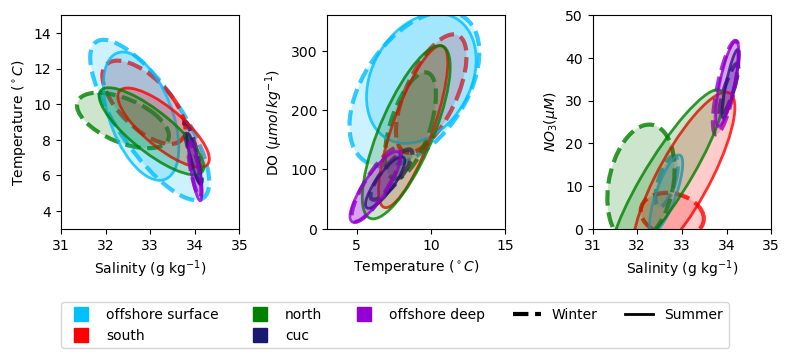

In [53]:
### ellipses of a few different tracers to show the difference between seasons
### i think that three plots across is the most we might see clearly

regions = ['offshore surface', 'south','north','cuc','offshore deep']
colour = ['deepskyblue','red','green','midnightblue','darkviolet']

fig, ax = plt.subplots(1,3,figsize=[8,3])

properties = ['salinity (g kg-1)','temperature (degC)']
ax[0].set_ylabel('Temperature ($^\circ C$)')
ax[0].set_xlabel('Salinity (g kg$^{-1}$)')
ax[0].set_xlim([31,35])
ax[0].set_ylim([3,15])
for i in range(len(regions)):
    if len(wob[(~np.isnan(wob[properties[1]]))&(wob.region == regions[i])]) > 0:
        ellipse = percentile_ellipse(np.array(wob[properties[0]][wob.region == regions[i]]), np.array(wob[properties[1]][wob.region == regions[i]]), 
                ax[0], percentile=75, facecolor='none',edgecolor=colour[i],lw=3,ls='dashed',  alpha=0.8)
        ax[0].add_patch(ellipse)
        ellipse = percentile_ellipse(np.array(wob[properties[0]][wob.region == regions[i]]), np.array(wob[properties[1]][wob.region == regions[i]]), 
                ax[0], percentile=75, facecolor=colour[i],edgecolor='none', alpha=0.2)
        ax[0].add_patch(ellipse)
for i in range(len(regions)):
    if len(sob[(~np.isnan(sob[properties[1]]))&(sob.region == regions[i])]) > 0:
        ellipse = percentile_ellipse(np.array(sob[properties[0]][sob.region == regions[i]]), np.array(sob[properties[1]][sob.region == regions[i]]), 
                ax[0], percentile=75, facecolor='none',edgecolor=colour[i],lw=2, alpha=0.8)
        ax[0].add_patch(ellipse)
        ellipse = percentile_ellipse(np.array(sob[properties[0]][sob.region == regions[i]]), np.array(sob[properties[1]][sob.region == regions[i]]), 
                ax[0], percentile=75, facecolor=colour[i],edgecolor='none',alpha=0.2)
        ax[0].add_patch(ellipse)

properties = ['temperature (degC)','DO (umol kg-1)']
ax[1].set_ylabel('DO ($\mu mol \, kg^{-1}$)')
ax[1].set_xlabel('Temperature ($^\circ C$)')
ax[1].set_xlim([3,15])
ax[1].set_ylim([0,360])
for i in range(len(regions)):
    if len(wob[(~np.isnan(wob[properties[1]]))&(wob.region == regions[i])]) > 0:
        ellipse = percentile_ellipse(np.array(wob[properties[0]][wob.region == regions[i]]), np.array(wob[properties[1]][wob.region == regions[i]]), 
                ax[1], percentile=75, facecolor='none',edgecolor=colour[i],lw=3, ls='dashed', alpha=0.8)
        ax[1].add_patch(ellipse)
        ellipse = percentile_ellipse(np.array(wob[properties[0]][wob.region == regions[i]]), np.array(wob[properties[1]][wob.region == regions[i]]), 
                ax[1], percentile=75, facecolor=colour[i],edgecolor='none', alpha=0.2)
        ax[1].add_patch(ellipse)
for i in range(len(regions)):
    if len(sob[(~np.isnan(sob[properties[1]]))&(sob.region == regions[i])]) > 0:
        ellipse = percentile_ellipse(np.array(sob[properties[0]][sob.region == regions[i]]), np.array(sob[properties[1]][sob.region == regions[i]]), 
                ax[1], percentile=75, facecolor='none',edgecolor=colour[i],lw=2, alpha=0.8)
        ax[1].add_patch(ellipse)
        ellipse = percentile_ellipse(np.array(sob[properties[0]][sob.region == regions[i]]), np.array(sob[properties[1]][sob.region == regions[i]]), 
                ax[1], percentile=75, facecolor=colour[i],edgecolor='none',alpha=0.2)
        ax[1].add_patch(ellipse)


properties = ['salinity (g kg-1)','NO3 (uM)']
ax[2].set_ylabel('$NO_3 (\mu M$)')
ax[2].set_xlabel('Salinity (g kg$^{-1}$)')
ax[2].set_xlim([31,35])
ax[2].set_ylim([0,50])
for i in range(len(regions)):
    if len(wob[(~np.isnan(wob[properties[1]]))&(wob.region == regions[i])]) > 0:
        ellipse = percentile_ellipse(np.array(wob[properties[0]][wob.region == regions[i]]), np.array(wob[properties[1]][wob.region == regions[i]]), 
                ax[2], percentile=75, facecolor='none',edgecolor=colour[i],lw=3, ls='dashed', alpha=0.8)
        ax[2].add_patch(ellipse)
        ellipse = percentile_ellipse(np.array(wob[properties[0]][wob.region == regions[i]]), np.array(wob[properties[1]][wob.region == regions[i]]), 
                ax[2], percentile=75, facecolor=colour[i],edgecolor='none', alpha=0.2)
        ax[2].add_patch(ellipse)
for i in range(len(regions)):
    if len(sob[(~np.isnan(sob[properties[1]]))&(sob.region == regions[i])]) > 0:
        ellipse = percentile_ellipse(np.array(sob[properties[0]][sob.region == regions[i]]), np.array(sob[properties[1]][sob.region == regions[i]]), 
                ax[2], percentile=75, facecolor='none',edgecolor=colour[i],lw=2, alpha=0.8)
        ax[2].add_patch(ellipse)
        ellipse = percentile_ellipse(np.array(sob[properties[0]][sob.region == regions[i]]), np.array(sob[properties[1]][sob.region == regions[i]]), 
                ax[2], percentile=75, facecolor=colour[i],edgecolor='none',alpha=0.2)
        ax[2].add_patch(ellipse)

# build legend handles    
legend_handles = []
for i in range(len(regions)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker='s', linestyle='None',markersize=10,
                          markeredgecolor=colour[i], markerfacecolor=colour[i],
                          label=regions[i]))
legend_handles.append(mlines.Line2D([], [], 
                          marker='none', linestyle='dashed',linewidth='3',
                          color='k',label='Winter'))
legend_handles.append(mlines.Line2D([], [], 
                          marker='none', linewidth='2',
                          color='k',label='Summer'))
# Add a figure-wide legend below the subplots
fig.legend(handles=legend_handles, loc='upper center', ncol=5, bbox_to_anchor=(0.5, -0.001), frameon=True)
plt.tight_layout()

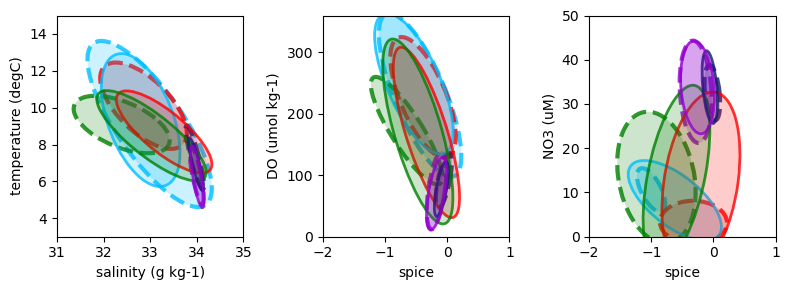

In [54]:
fig, ax = plt.subplots(1,3,figsize=[8,3])

properties = ['salinity (g kg-1)','temperature (degC)']
ax[0].set_ylabel(properties[1])
ax[0].set_xlabel(properties[0])
ax[0].set_xlim([31,35])
ax[0].set_ylim([3,15])
for i in range(len(regions)):
    if len(wob[(~np.isnan(wob[properties[1]]))&(wob.region == regions[i])]) > 0:
        ellipse = percentile_ellipse(np.array(wob[properties[0]][wob.region == regions[i]]), np.array(wob[properties[1]][wob.region == regions[i]]), 
                ax[0], percentile=75, facecolor='none',edgecolor=colour[i],lw=3,ls='dashed',  alpha=0.8)
        ax[0].add_patch(ellipse)
        ellipse = percentile_ellipse(np.array(wob[properties[0]][wob.region == regions[i]]), np.array(wob[properties[1]][wob.region == regions[i]]), 
                ax[0], percentile=75, facecolor=colour[i],edgecolor='none', alpha=0.2)
        ax[0].add_patch(ellipse)
for i in range(len(regions)):
    if len(sob[(~np.isnan(sob[properties[1]]))&(sob.region == regions[i])]) > 0:
        ellipse = percentile_ellipse(np.array(sob[properties[0]][sob.region == regions[i]]), np.array(sob[properties[1]][sob.region == regions[i]]), 
                ax[0], percentile=75, facecolor='none',edgecolor=colour[i],lw=2, alpha=0.8)
        ax[0].add_patch(ellipse)
        ellipse = percentile_ellipse(np.array(sob[properties[0]][sob.region == regions[i]]), np.array(sob[properties[1]][sob.region == regions[i]]), 
                ax[0], percentile=75, facecolor=colour[i],edgecolor='none',alpha=0.2)
        ax[0].add_patch(ellipse)

properties = ['spice','DO (umol kg-1)']
ax[1].set_ylabel(properties[1])
ax[1].set_xlabel(properties[0])
ax[1].set_xlim([-2,1])
ax[1].set_ylim([0,360])
for i in range(len(regions)):
    if len(wob[(~np.isnan(wob[properties[1]]))&(wob.region == regions[i])]) > 0:
        ellipse = percentile_ellipse(np.array(wob[properties[0]][wob.region == regions[i]]), np.array(wob[properties[1]][wob.region == regions[i]]), 
                ax[1], percentile=75, facecolor='none',edgecolor=colour[i],lw=3, ls='dashed', alpha=0.8)
        ax[1].add_patch(ellipse)
        ellipse = percentile_ellipse(np.array(wob[properties[0]][wob.region == regions[i]]), np.array(wob[properties[1]][wob.region == regions[i]]), 
                ax[1], percentile=75, facecolor=colour[i],edgecolor='none', alpha=0.2)
        ax[1].add_patch(ellipse)
for i in range(len(regions)):
    if len(sob[(~np.isnan(sob[properties[1]]))&(sob.region == regions[i])]) > 0:
        ellipse = percentile_ellipse(np.array(sob[properties[0]][sob.region == regions[i]]), np.array(sob[properties[1]][sob.region == regions[i]]), 
                ax[1], percentile=75, facecolor='none',edgecolor=colour[i],lw=2, alpha=0.8)
        ax[1].add_patch(ellipse)
        ellipse = percentile_ellipse(np.array(sob[properties[0]][sob.region == regions[i]]), np.array(sob[properties[1]][sob.region == regions[i]]), 
                ax[1], percentile=75, facecolor=colour[i],edgecolor='none',alpha=0.2)
        ax[1].add_patch(ellipse)


properties = ['spice','NO3 (uM)']
ax[2].set_ylabel(properties[1])
ax[2].set_xlabel(properties[0])
ax[2].set_xlim([-2,1])
ax[2].set_ylim([0,50])
for i in range(len(regions)):
    ellipse = percentile_ellipse(np.array(wob[properties[0]][wob.region == regions[i]]), np.array(wob[properties[1]][wob.region == regions[i]]), 
            ax[2], percentile=75, facecolor='none',edgecolor=colour[i],lw=3, ls='dashed', alpha=0.8)
    ax[2].add_patch(ellipse)
    ellipse = percentile_ellipse(np.array(wob[properties[0]][wob.region == regions[i]]), np.array(wob[properties[1]][wob.region == regions[i]]), 
            ax[2], percentile=75, facecolor=colour[i],edgecolor='none', alpha=0.2)
    ax[2].add_patch(ellipse)
for i in range(len(regions)):
    ellipse = percentile_ellipse(np.array(sob[properties[0]][sob.region == regions[i]]), np.array(sob[properties[1]][sob.region == regions[i]]), 
            ax[2], percentile=75, facecolor='none',edgecolor=colour[i],lw=2, alpha=0.8)
    ax[2].add_patch(ellipse)
    ellipse = percentile_ellipse(np.array(sob[properties[0]][sob.region == regions[i]]), np.array(sob[properties[1]][sob.region == regions[i]]), 
            ax[2], percentile=75, facecolor=colour[i],edgecolor='none',alpha=0.2)
    ax[2].add_patch(ellipse)

plt.tight_layout()

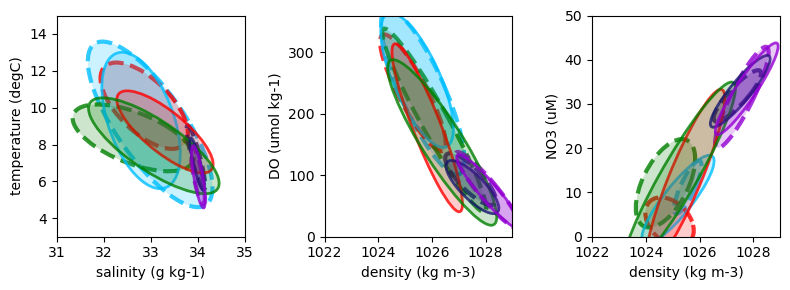

In [46]:
fig, ax = plt.subplots(1,3,figsize=[8,3])

properties = ['salinity (g kg-1)','temperature (degC)']
ax[0].set_ylabel(properties[1])
ax[0].set_xlabel(properties[0])
ax[0].set_xlim([31,35])
ax[0].set_ylim([3,15])
for i in range(len(regions)):
    if len(wob[(~np.isnan(wob[properties[1]]))&(wob.region == regions[i])]) > 0:
        ellipse = percentile_ellipse(np.array(wob[properties[0]][wob.region == regions[i]]), np.array(wob[properties[1]][wob.region == regions[i]]), 
                ax[0], percentile=75, facecolor='none',edgecolor=colour[i],lw=3,ls='dashed',  alpha=0.8)
        ax[0].add_patch(ellipse)
        ellipse = percentile_ellipse(np.array(wob[properties[0]][wob.region == regions[i]]), np.array(wob[properties[1]][wob.region == regions[i]]), 
                ax[0], percentile=75, facecolor=colour[i],edgecolor='none', alpha=0.2)
        ax[0].add_patch(ellipse)
for i in range(len(regions)):
    if len(sob[(~np.isnan(sob[properties[1]]))&(sob.region == regions[i])]) > 0:
        ellipse = percentile_ellipse(np.array(sob[properties[0]][sob.region == regions[i]]), np.array(sob[properties[1]][sob.region == regions[i]]), 
                ax[0], percentile=75, facecolor='none',edgecolor=colour[i],lw=2, alpha=0.8)
        ax[0].add_patch(ellipse)
        ellipse = percentile_ellipse(np.array(sob[properties[0]][sob.region == regions[i]]), np.array(sob[properties[1]][sob.region == regions[i]]), 
                ax[0], percentile=75, facecolor=colour[i],edgecolor='none',alpha=0.2)
        ax[0].add_patch(ellipse)

properties = ['density (kg m-3)','DO (umol kg-1)']
ax[1].set_ylabel(properties[1])
ax[1].set_xlabel(properties[0])
ax[1].set_xlim([1022,1029])
ax[1].set_ylim([0,360])
for i in range(len(regions)):
    if len(wob[(~np.isnan(wob[properties[1]]))&(wob.region == regions[i])]) > 0:
        ellipse = percentile_ellipse(np.array(wob[properties[0]][wob.region == regions[i]]), np.array(wob[properties[1]][wob.region == regions[i]]), 
                ax[1], percentile=75, facecolor='none',edgecolor=colour[i],lw=3, ls='dashed', alpha=0.8)
        ax[1].add_patch(ellipse)
        ellipse = percentile_ellipse(np.array(wob[properties[0]][wob.region == regions[i]]), np.array(wob[properties[1]][wob.region == regions[i]]), 
                ax[1], percentile=75, facecolor=colour[i],edgecolor='none', alpha=0.2)
        ax[1].add_patch(ellipse)
for i in range(len(regions)):
    if len(sob[(~np.isnan(sob[properties[1]]))&(sob.region == regions[i])]) > 0:
        ellipse = percentile_ellipse(np.array(sob[properties[0]][sob.region == regions[i]]), np.array(sob[properties[1]][sob.region == regions[i]]), 
                ax[1], percentile=75, facecolor='none',edgecolor=colour[i],lw=2, alpha=0.8)
        ax[1].add_patch(ellipse)
        ellipse = percentile_ellipse(np.array(sob[properties[0]][sob.region == regions[i]]), np.array(sob[properties[1]][sob.region == regions[i]]), 
                ax[1], percentile=75, facecolor=colour[i],edgecolor='none',alpha=0.2)
        ax[1].add_patch(ellipse)


properties = ['density (kg m-3)','NO3 (uM)']
ax[2].set_ylabel(properties[1])
ax[2].set_xlabel(properties[0])
ax[2].set_xlim([1022,1029])
ax[2].set_ylim([0,50])
for i in range(len(regions)):
    ellipse = percentile_ellipse(np.array(wob[properties[0]][wob.region == regions[i]]), np.array(wob[properties[1]][wob.region == regions[i]]), 
            ax[2], percentile=75, facecolor='none',edgecolor=colour[i],lw=3, ls='dashed', alpha=0.8)
    ax[2].add_patch(ellipse)
    ellipse = percentile_ellipse(np.array(wob[properties[0]][wob.region == regions[i]]), np.array(wob[properties[1]][wob.region == regions[i]]), 
            ax[2], percentile=75, facecolor=colour[i],edgecolor='none', alpha=0.2)
    ax[2].add_patch(ellipse)
for i in range(len(regions)):
    ellipse = percentile_ellipse(np.array(sob[properties[0]][sob.region == regions[i]]), np.array(sob[properties[1]][sob.region == regions[i]]), 
            ax[2], percentile=75, facecolor='none',edgecolor=colour[i],lw=2, alpha=0.8)
    ax[2].add_patch(ellipse)
    ellipse = percentile_ellipse(np.array(sob[properties[0]][sob.region == regions[i]]), np.array(sob[properties[1]][sob.region == regions[i]]), 
            ax[2], percentile=75, facecolor=colour[i],edgecolor='none',alpha=0.2)
    ax[2].add_patch(ellipse)

plt.tight_layout()

In [47]:
# plots of average properties of each water mass over time
# year averages
obs['year'] = [obs.time[i].year for i in range(len(obs))]
aggregation_dict = {col: 'mean' for col in ['temperature (degC)', 'salinity (g kg-1)', 'DO (umol kg-1)', 'NO3 (uM)',
       'NO2 (uM)', 'NH4 (uM)', 'PO4 (uM)', 'SiO4 (uM)', 'Chl (mg m-3)', 'TA (uM)', 'DIC (uM)', 'Carbonate', 'Aragonite', 'Calcite',
       'Cd (nmol kg-1)', 'Co (nmol kg-1)', 'Cu (nmol kg-1)', 'Fe (nmol kg-1)', 'Mn (nmol kg-1)', 'Ni (nmol kg-1)', 'Zn (nmol kg-1)',
       'Nstar (umol kg-1)', 'spice', 'density (kg m-3)']}
obs_year = obs.groupby(['year', 'season', 'region']).agg(aggregation_dict).reset_index()

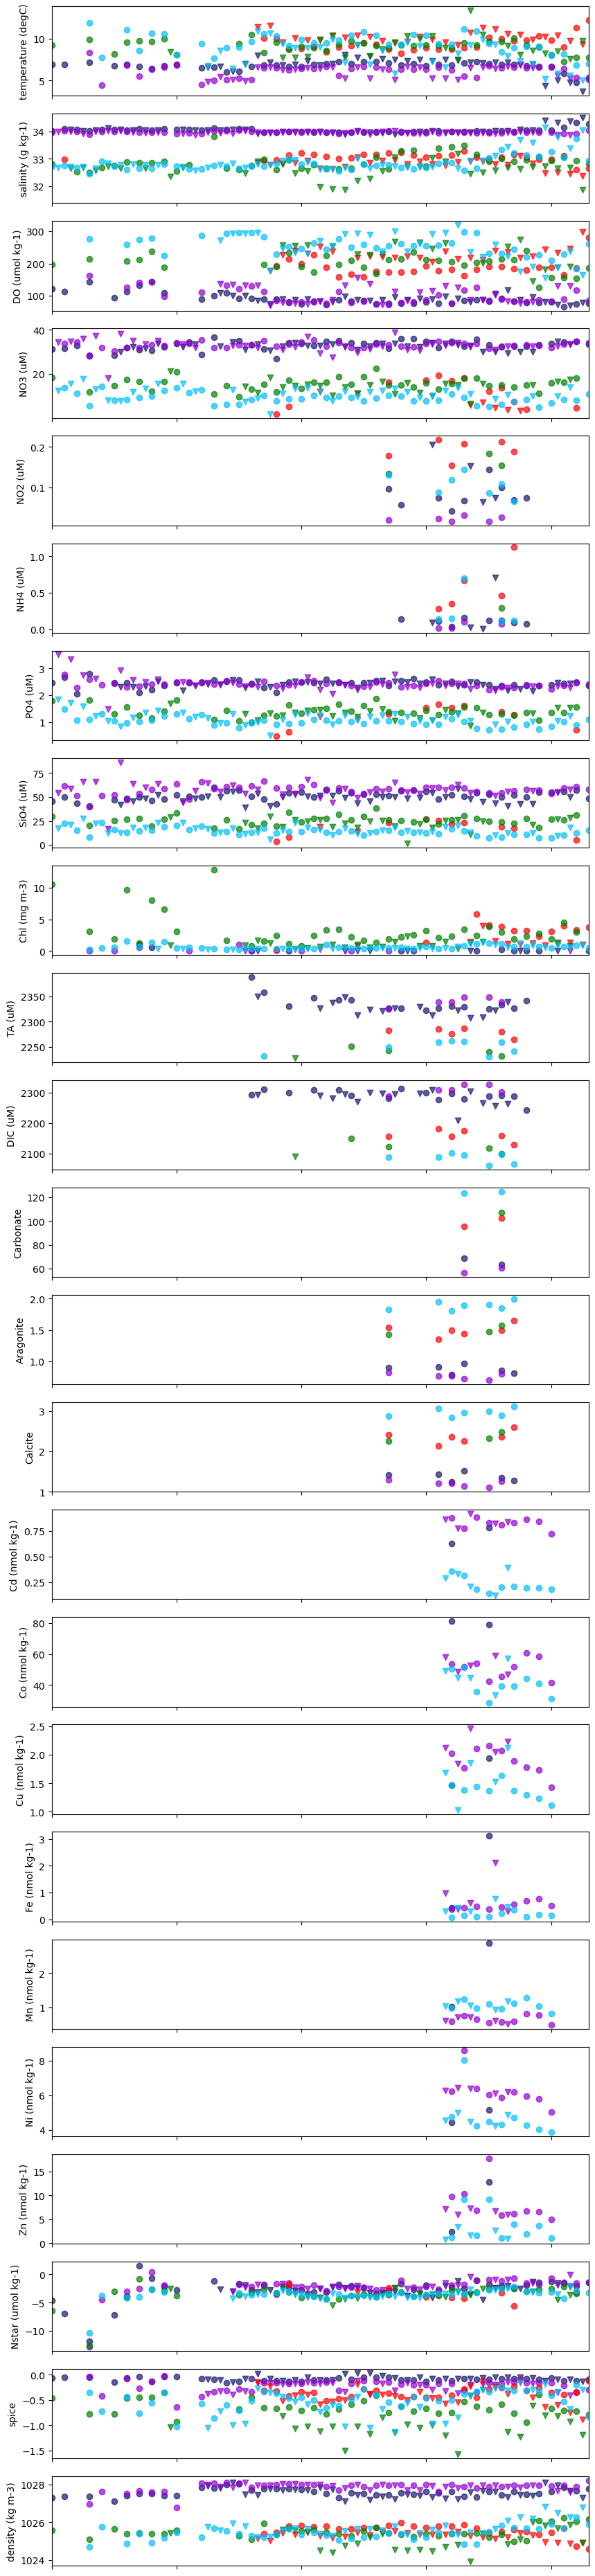

In [48]:
properties = ['temperature (degC)', 'salinity (g kg-1)', 'DO (umol kg-1)', 'NO3 (uM)',
       'NO2 (uM)', 'NH4 (uM)', 'PO4 (uM)', 'SiO4 (uM)', 'Chl (mg m-3)', 'TA (uM)', 'DIC (uM)', 'Carbonate', 'Aragonite', 'Calcite',
       'Cd (nmol kg-1)', 'Co (nmol kg-1)', 'Cu (nmol kg-1)', 'Fe (nmol kg-1)', 'Mn (nmol kg-1)', 'Ni (nmol kg-1)', 'Zn (nmol kg-1)',
       'Nstar (umol kg-1)', 'spice', 'density (kg m-3)']

fig, ax = plt.subplots(len(properties),1,figsize=[10,2*len(properties)])

for i in range(len(properties)):
    ax[i].set_xlim([1980,2023]) # for the sake of good data coverage
    ax[i].set_xticks(np.arange(1980,2023,10))
    ax[i].set_xticklabels([])

    prop = properties[i]
    ax[i].set_ylabel(prop)
    ax[i].scatter(obs_year.year[(obs_year.region == 'cuc')&(obs_year.season == 'up')],obs_year[prop][(obs_year.region == 'cuc')&(obs_year.season == 'up')],color='midnightblue',marker='o',alpha=0.7)
    ax[i].scatter(obs_year.year[(obs_year.region == 'cuc')&(obs_year.season == 'down')]-0.5,obs_year[prop][(obs_year.region == 'cuc')&(obs_year.season == 'down')],color='midnightblue',marker='v',alpha=0.7)
    ax[i].scatter(obs_year.year[(obs_year.region == 'offshore deep')&(obs_year.season == 'up')],obs_year[prop][(obs_year.region == 'offshore deep')&(obs_year.season == 'up')],color='darkviolet',marker='o',alpha=0.7)
    ax[i].scatter(obs_year.year[(obs_year.region == 'offshore deep')&(obs_year.season == 'down')]-0.5,obs_year[prop][(obs_year.region == 'offshore deep')&(obs_year.season == 'down')],color='darkviolet',marker='v',alpha=0.7)
    ax[i].scatter(obs_year.year[(obs_year.region == 'south')&(obs_year.season == 'up')],obs_year[prop][(obs_year.region == 'south')&(obs_year.season == 'up')],color='r',marker='o',alpha=0.7)
    ax[i].scatter(obs_year.year[(obs_year.region == 'south')&(obs_year.season == 'down')]-0.5,obs_year[prop][(obs_year.region == 'south')&(obs_year.season == 'down')],color='r',marker='v',alpha=0.7)
    ax[i].scatter(obs_year.year[(obs_year.region == 'north')&(obs_year.season == 'up')],obs_year[prop][(obs_year.region == 'north')&(obs_year.season == 'up')],color='green',marker='o',alpha=0.7)
    ax[i].scatter(obs_year.year[(obs_year.region == 'north')&(obs_year.season == 'down')]-0.5,obs_year[prop][(obs_year.region == 'north')&(obs_year.season == 'down')],color='green',marker='v',alpha=0.7)
    ax[i].scatter(obs_year.year[(obs_year.region == 'offshore surface')&(obs_year.season == 'up')],obs_year[prop][(obs_year.region == 'offshore surface')&(obs_year.season == 'up')],color='deepskyblue',marker='o',alpha=0.7)
    ax[i].scatter(obs_year.year[(obs_year.region == 'offshore surface')&(obs_year.season == 'down')]-0.5,obs_year[prop][(obs_year.region == 'offshore surface')&(obs_year.season == 'down')],color='deepskyblue',marker='v',alpha=0.7)


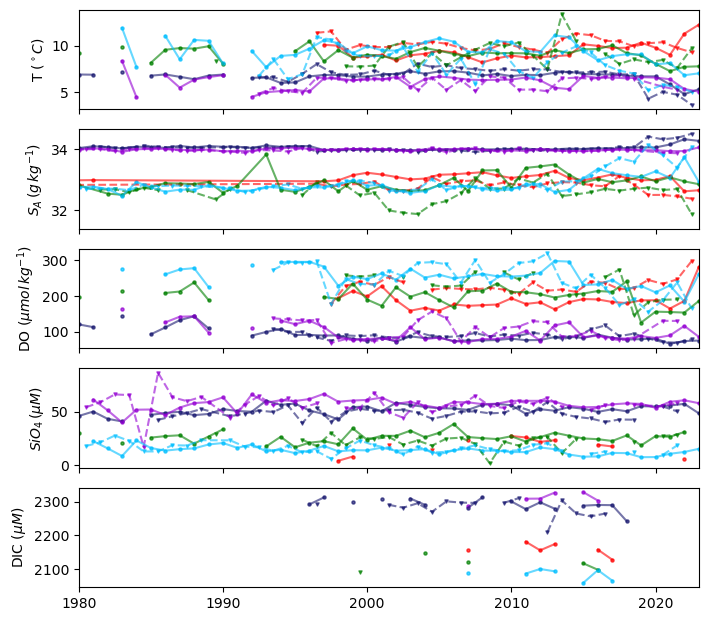

In [49]:
# subset that have good coverage
properties = ['temperature (degC)', 'salinity (g kg-1)','DO (umol kg-1)', 'SiO4 (uM)','DIC (uM)']
labels = ['T ($^\circ C$)', '$S_A \,(g \,kg^{-1})$','DO ($\mu mol \, kg^{-1})$', '$SiO_4 \,(\mu M)$','DIC ($\mu M$)']

fig, ax = plt.subplots(len(properties),1,figsize=[8,1.5*len(properties)])

for i in range(len(properties)):
    ax[i].set_xlim([1980,2023]) # for the sake of good data coverage
    ax[i].set_xticks(np.arange(1980,2023,10))
    ax[i].set_xticklabels([])

    prop = properties[i]
    ax[i].set_ylabel(labels[i])
    ax[i].scatter(obs_year.year[(obs_year.region == 'cuc')&(obs_year.season == 'up')],obs_year[prop][(obs_year.region == 'cuc')&(obs_year.season == 'up')],color='midnightblue',marker='o',alpha=0.7,s=5)
    ax[i].scatter(obs_year.year[(obs_year.region == 'cuc')&(obs_year.season == 'down')]-0.5,obs_year[prop][(obs_year.region == 'cuc')&(obs_year.season == 'down')],color='midnightblue',marker='v',alpha=0.7,s=5)
    ax[i].scatter(obs_year.year[(obs_year.region == 'offshore deep')&(obs_year.season == 'up')],obs_year[prop][(obs_year.region == 'offshore deep')&(obs_year.season == 'up')],color='darkviolet',marker='o',alpha=0.7,s=5)
    ax[i].scatter(obs_year.year[(obs_year.region == 'offshore deep')&(obs_year.season == 'down')]-0.5,obs_year[prop][(obs_year.region == 'offshore deep')&(obs_year.season == 'down')],color='darkviolet',marker='v',alpha=0.7,s=5)
    ax[i].scatter(obs_year.year[(obs_year.region == 'south')&(obs_year.season == 'up')],obs_year[prop][(obs_year.region == 'south')&(obs_year.season == 'up')],color='r',marker='o',alpha=0.7,s=5)
    ax[i].scatter(obs_year.year[(obs_year.region == 'south')&(obs_year.season == 'down')]-0.5,obs_year[prop][(obs_year.region == 'south')&(obs_year.season == 'down')],color='r',marker='v',alpha=0.7,s=5)
    ax[i].scatter(obs_year.year[(obs_year.region == 'north')&(obs_year.season == 'up')],obs_year[prop][(obs_year.region == 'north')&(obs_year.season == 'up')],color='green',marker='o',alpha=0.7,s=5)
    ax[i].scatter(obs_year.year[(obs_year.region == 'north')&(obs_year.season == 'down')]-0.5,obs_year[prop][(obs_year.region == 'north')&(obs_year.season == 'down')],color='green',marker='v',alpha=0.7,s=5)
    ax[i].scatter(obs_year.year[(obs_year.region == 'offshore surface')&(obs_year.season == 'up')],obs_year[prop][(obs_year.region == 'offshore surface')&(obs_year.season == 'up')],color='deepskyblue',marker='o',alpha=0.7,s=5)
    ax[i].scatter(obs_year.year[(obs_year.region == 'offshore surface')&(obs_year.season == 'down')]-0.5,obs_year[prop][(obs_year.region == 'offshore surface')&(obs_year.season == 'down')],color='deepskyblue',marker='v',alpha=0.7,s=5)

    ax[i].plot(obs_year.year[(obs_year.region == 'cuc')&(obs_year.season == 'up')],obs_year[prop][(obs_year.region == 'cuc')&(obs_year.season == 'up')],color='midnightblue',alpha=0.6)
    ax[i].plot(obs_year.year[(obs_year.region == 'cuc')&(obs_year.season == 'down')]-0.5,obs_year[prop][(obs_year.region == 'cuc')&(obs_year.season == 'down')],color='midnightblue',ls='dashed',alpha=0.6)
    ax[i].plot(obs_year.year[(obs_year.region == 'offshore deep')&(obs_year.season == 'up')],obs_year[prop][(obs_year.region == 'offshore deep')&(obs_year.season == 'up')],color='darkviolet',alpha=0.6)
    ax[i].plot(obs_year.year[(obs_year.region == 'offshore deep')&(obs_year.season == 'down')]-0.5,obs_year[prop][(obs_year.region == 'offshore deep')&(obs_year.season == 'down')],color='darkviolet',ls='dashed',alpha=0.6)
    ax[i].plot(obs_year.year[(obs_year.region == 'south')&(obs_year.season == 'up')],obs_year[prop][(obs_year.region == 'south')&(obs_year.season == 'up')],color='r',alpha=0.6)
    ax[i].plot(obs_year.year[(obs_year.region == 'south')&(obs_year.season == 'down')]-0.5,obs_year[prop][(obs_year.region == 'south')&(obs_year.season == 'down')],color='r',ls='dashed',alpha=0.6)
    ax[i].plot(obs_year.year[(obs_year.region == 'north')&(obs_year.season == 'up')],obs_year[prop][(obs_year.region == 'north')&(obs_year.season == 'up')],color='green',alpha=0.6)
    ax[i].plot(obs_year.year[(obs_year.region == 'north')&(obs_year.season == 'down')]-0.5,obs_year[prop][(obs_year.region == 'north')&(obs_year.season == 'down')],color='green',ls='dashed',alpha=0.6)
    ax[i].plot(obs_year.year[(obs_year.region == 'offshore surface')&(obs_year.season == 'up')],obs_year[prop][(obs_year.region == 'offshore surface')&(obs_year.season == 'up')],color='deepskyblue',alpha=0.6)
    ax[i].plot(obs_year.year[(obs_year.region == 'offshore surface')&(obs_year.season == 'down')]-0.5,obs_year[prop][(obs_year.region == 'offshore surface')&(obs_year.season == 'down')],color='deepskyblue',ls='dashed',alpha=0.6)
ax[len(properties)-1].set_xticklabels(np.arange(1980,2023,10));

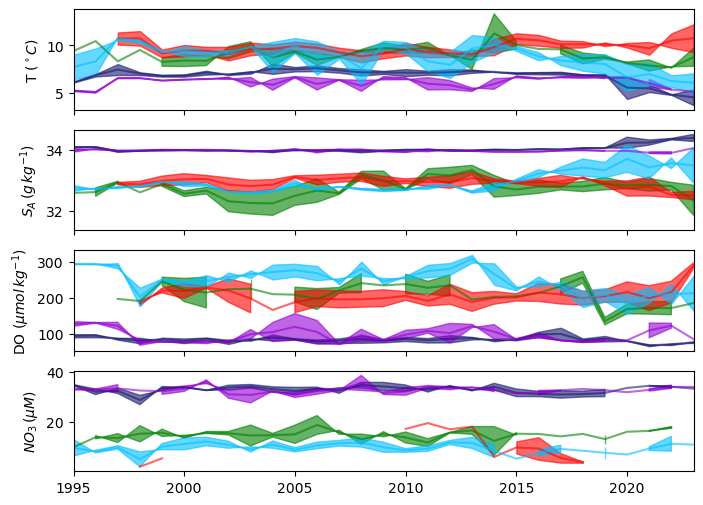

In [50]:
# subset that have good coverage
# fill between the upwelling and downwelling line

# put winter and summer into the arrays of the same length, space between to show interannual variability, 

# make all columns float 
properties = ['temperature (degC)', 'salinity (g kg-1)','DO (umol kg-1)', 'NO3 (uM)']
obs_year[properties] = obs_year[properties].apply(pd.to_numeric, errors='coerce')
# up = obs_year[prop][(obs_year.region == 'cuc')&(obs_year.season == 'up')]
# down = obs_year[prop][(obs_year.region == 'cuc')&(obs_year.season == 'down')]
updwn = np.full([len(set(obs_year.year))*2], np.nan)
years = list(set(obs_year.year))
def fillarrays(prop,region):
    up = np.full([len(set(obs_year.year))], np.nan)
    dw = np.full([len(set(obs_year.year))], np.nan)

    i=0
    for y in set(obs_year.year):
        if len(obs_year[prop][(obs_year.region == region)&(obs_year.season == 'up')&(obs_year.year == y)]) >0 :
            up[i] = float(obs_year[prop][(obs_year.region == region)&(obs_year.season == 'up')&(obs_year.year == y)])
        if len(obs_year[prop][(obs_year.region == region)&(obs_year.season == 'down')&(obs_year.year == y)]) >0 :    
            dw[i] = float(obs_year[prop][(obs_year.region == region)&(obs_year.season == 'down')&(obs_year.year == y)])
        i+=1
    return up, dw

labels = ['T ($^\circ C$)', '$S_A \,(g \,kg^{-1})$','DO ($\mu mol \, kg^{-1})$', '$NO_3 \,(\mu M)$']

fig, ax = plt.subplots(len(properties),1,figsize=[8,1.5*len(properties)])

for i in range(len(properties)):
    ax[i].set_xlim([1995,2023]) # for the sake of good data coverage
    ax[i].set_xticks(np.arange(1995,2023,5))
    ax[i].set_xticklabels([])

    prop = properties[i]
    ax[i].set_ylabel(labels[i])

    up,dw = fillarrays(prop,'cuc')
    ax[i].fill_between(years,up,dw,color='midnightblue',alpha=0.6)
    ax[i].plot(years,np.nanmean([up,dw],axis=0),color='midnightblue',alpha=0.6)

    up,dw = fillarrays(prop,'offshore deep')
    ax[i].fill_between(years,up,dw,color='darkviolet',alpha=0.6)
    ax[i].plot(years,np.nanmean([up,dw],axis=0),color='darkviolet',alpha=0.6)

    up,dw = fillarrays(prop,'north')
    ax[i].fill_between(years,up,dw,color='green',alpha=0.6)
    ax[i].plot(years,np.nanmean([up,dw],axis=0),color='green',alpha=0.6)

    up,dw = fillarrays(prop,'south')
    ax[i].fill_between(years,up,dw,color='red',alpha=0.6)
    ax[i].plot(years,np.nanmean([up,dw],axis=0),color='red',alpha=0.6)

    up,dw = fillarrays(prop,'offshore surface')
    ax[i].fill_between(years,up,dw,color='deepskyblue',alpha=0.6)
    ax[i].plot(years,np.nanmean([up,dw],axis=0),color='deepskyblue',alpha=0.6)

ax[3].set_xticklabels(np.arange(1995,2023,5));

    

In [51]:
# put winter and summer into the same array and use line to show variability (or lack thereof)

# make all columns float 
properties = ['temperature (degC)', 'salinity (g kg-1)', 'DO (umol kg-1)', 'NO3 (uM)',
       'NO2 (uM)', 'NH4 (uM)', 'PO4 (uM)', 'SiO4 (uM)', 'Chl (mg m-3)', 'TA (uM)', 'DIC (uM)', 'Carbonate', 'Aragonite', 'Calcite',
       'Cd (nmol kg-1)', 'Co (nmol kg-1)', 'Cu (nmol kg-1)', 'Fe (nmol kg-1)', 'Mn (nmol kg-1)', 'Ni (nmol kg-1)', 'Zn (nmol kg-1)',
       'Nstar (umol kg-1)', 'spice', 'density (kg m-3)']
obs_year[properties] = obs_year[properties].apply(pd.to_numeric, errors='coerce')


# up = obs_year[prop][(obs_year.region == 'cuc')&(obs_year.season == 'up')]
# down = obs_year[prop][(obs_year.region == 'cuc')&(obs_year.season == 'down')]
updwn = np.full([len(set(obs_year.year))*2], np.nan)

In [52]:
def updown(prop,region):
    updwn = np.full([len(set(obs_year.year))*2], np.nan)

    i=0
    for y in set(obs_year.year):
        if len(obs_year[prop][(obs_year.region == region)&(obs_year.season == 'up')&(obs_year.year == y)]) >0 :
            updwn[i] = float(obs_year[prop][(obs_year.region == region)&(obs_year.season == 'up')&(obs_year.year == y)])
        if len(obs_year[prop][(obs_year.region == region)&(obs_year.season == 'down')&(obs_year.year == y)]) >0 :    
            updwn[i+1] = float(obs_year[prop][(obs_year.region == region)&(obs_year.season == 'down')&(obs_year.year == y)])
        i+=2
    return updwn

In [53]:
years = np.zeros(len(set(obs_year.year))*2)
years[::2] = list(set(obs_year.year))
years[1::2] = [list(set(obs_year.year))[i]+0.5 for i in range(len(set(obs_year.year)))]

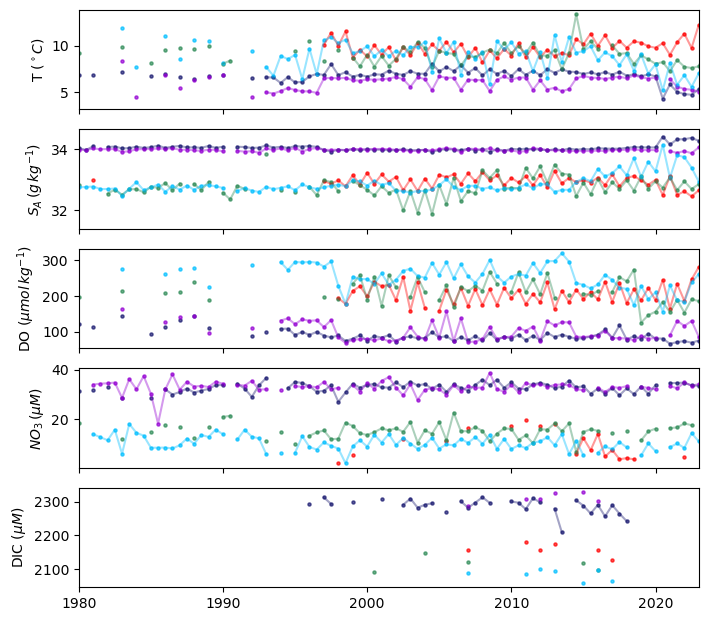

In [54]:
# subset that have good coverage
properties = ['temperature (degC)', 'salinity (g kg-1)','DO (umol kg-1)', 'NO3 (uM)','DIC (uM)']
labels = ['T ($^\circ C$)', '$S_A \,(g \,kg^{-1})$','DO ($\mu mol \, kg^{-1})$', '$NO_3 \,(\mu M)$','DIC ($\mu M$)']

fig, ax = plt.subplots(len(properties),1,figsize=[8,1.5*len(properties)])

for i in range(len(properties)):
    ax[i].set_xlim([1980,2023]) # for the sake of good data coverage
    ax[i].set_xticks(np.arange(1980,2023,10))
    ax[i].set_xticklabels([])

    prop = properties[i]
    ax[i].set_ylabel(labels[i])
    ax[i].scatter(years,updown(prop,'cuc'),color='midnightblue',marker='o',alpha=0.7,s=5)
    ax[i].scatter(years,updown(prop,'offshore deep'),color='darkviolet',marker='o',alpha=0.7,s=5)
    ax[i].scatter(years,updown(prop,'south'),color='r',marker='o',alpha=0.7,s=5)
    ax[i].scatter(years,updown(prop,'north'),color='seagreen',marker='o',alpha=0.7,s=5)
    ax[i].scatter(years,updown(prop,'offshore surface'),color='deepskyblue',marker='o',alpha=0.7,s=5)

    ax[i].plot(years,updown(prop,'cuc'),color='midnightblue',alpha=0.4)
    ax[i].plot(years,updown(prop,'offshore deep'),color='darkviolet',alpha=0.4)
    ax[i].plot(years,updown(prop,'south'),color='r',alpha=0.4)
    ax[i].plot(years,updown(prop,'north'),color='seagreen',alpha=0.4)
    ax[i].plot(years,updown(prop,'offshore surface'),color='deepskyblue',alpha=0.4)
ax[len(properties)-1].set_xticklabels(np.arange(1980,2023,10));

plt.savefig('property_timeseries.pdf')

north upwelling (downwelling) = inconsistent NO3, low (high) DO, high (low) Salinity* , warm (cold) temperature*
south upwelling (downwelling) = low (high) DO, high (low) Salinity , cold (warm) temperature*
offshore surface upwelling (downwelling) = low (high) NO3, low (high) DO*, low (high) Salinity*, warm (cold) temperature*
*interannual varaibility also clearly important 

In [55]:
# correlation between water mass property variability
print("Temperature")
prop = "temperature (degC)"
cuc = updown(prop,'cuc')
offd = updown(prop,'offshore deep')
offs = updown(prop,'offshore surface')
nor = updown(prop,'north')
south = updown(prop,'south')
corr, _ = pearsonr(cuc[(~np.isnan(cuc))&(~np.isnan(offd))],offd[(~np.isnan(cuc))&(~np.isnan(offd))])
print('Pearsons correlation, cuc v. offshore deep: %.3f' % corr)
corr, _ = pearsonr(cuc[(~np.isnan(cuc))&(~np.isnan(offs))],offs[(~np.isnan(cuc))&(~np.isnan(offs))])
print('Pearsons correlation, cuc v. offshore surface: %.3f' % corr)
corr, _ = pearsonr(cuc[(~np.isnan(cuc))&(~np.isnan(nor))],nor[(~np.isnan(cuc))&(~np.isnan(nor))])
print('Pearsons correlation, cuc v. north: %.3f' % corr)
corr, _ = pearsonr(cuc[(~np.isnan(cuc))&(~np.isnan(south))],south[(~np.isnan(cuc))&(~np.isnan(south))])
print('Pearsons correlation, cuc v. south: %.3f' % corr)
corr, _ = pearsonr(offd[(~np.isnan(offd))&(~np.isnan(offs))],offs[(~np.isnan(offd))&(~np.isnan(offs))])
print('Pearsons correlation, offshore deep v. offshore surface: %.3f' % corr)
corr, _ = pearsonr(offd[(~np.isnan(offd))&(~np.isnan(nor))],nor[(~np.isnan(offd))&(~np.isnan(nor))])
print('Pearsons correlation, offshore deep v. north: %.3f' % corr)
corr, _ = pearsonr(offd[(~np.isnan(offd))&(~np.isnan(south))],south[(~np.isnan(offd))&(~np.isnan(south))])
print('Pearsons correlation, offshore deep v. south: %.3f' % corr)
corr, _ = pearsonr(offs[(~np.isnan(offs))&(~np.isnan(nor))],nor[(~np.isnan(offs))&(~np.isnan(nor))])
print('Pearsons correlation, offshore surface v. north: %.3f' % corr)
corr, _ = pearsonr(offs[(~np.isnan(offs))&(~np.isnan(south))],south[(~np.isnan(offs))&(~np.isnan(south))])
print('Pearsons correlation, offshore surface v. south: %.3f' % corr)
corr, _ = pearsonr(nor[(~np.isnan(nor))&(~np.isnan(south))],south[(~np.isnan(nor))&(~np.isnan(south))])
print('Pearsons correlation, north v. south: %.3f' % corr)
print("\n")


print("Salinity")
prop = "salinity (g kg-1)"
cuc = updown(prop,'cuc')
offd = updown(prop,'offshore deep')
offs = updown(prop,'offshore surface')
nor = updown(prop,'north')
south = updown(prop,'south')
corr, _ = pearsonr(cuc[(~np.isnan(cuc))&(~np.isnan(offd))],offd[(~np.isnan(cuc))&(~np.isnan(offd))])
print('Pearsons correlation, cuc v. offshore deep: %.3f' % corr)
corr, _ = pearsonr(cuc[(~np.isnan(cuc))&(~np.isnan(offs))],offs[(~np.isnan(cuc))&(~np.isnan(offs))])
print('Pearsons correlation, cuc v. offshore surface: %.3f' % corr)
corr, _ = pearsonr(cuc[(~np.isnan(cuc))&(~np.isnan(nor))],nor[(~np.isnan(cuc))&(~np.isnan(nor))])
print('Pearsons correlation, cuc v. north: %.3f' % corr)
corr, _ = pearsonr(cuc[(~np.isnan(cuc))&(~np.isnan(south))],south[(~np.isnan(cuc))&(~np.isnan(south))])
print('Pearsons correlation, cuc v. south: %.3f' % corr)
corr, _ = pearsonr(offd[(~np.isnan(offd))&(~np.isnan(offs))],offs[(~np.isnan(offd))&(~np.isnan(offs))])
print('Pearsons correlation, offshore deep v. offshore surface: %.3f' % corr)
corr, _ = pearsonr(offd[(~np.isnan(offd))&(~np.isnan(nor))],nor[(~np.isnan(offd))&(~np.isnan(nor))])
print('Pearsons correlation, offshore deep v. north: %.3f' % corr)
corr, _ = pearsonr(offd[(~np.isnan(offd))&(~np.isnan(south))],south[(~np.isnan(offd))&(~np.isnan(south))])
print('Pearsons correlation, offshore deep v. south: %.3f' % corr)
corr, _ = pearsonr(offs[(~np.isnan(offs))&(~np.isnan(nor))],nor[(~np.isnan(offs))&(~np.isnan(nor))])
print('Pearsons correlation, offshore surface v. north: %.3f' % corr)
corr, _ = pearsonr(offs[(~np.isnan(offs))&(~np.isnan(south))],south[(~np.isnan(offs))&(~np.isnan(south))])
print('Pearsons correlation, offshore surface v. south: %.3f' % corr)
corr, _ = pearsonr(nor[(~np.isnan(nor))&(~np.isnan(south))],south[(~np.isnan(nor))&(~np.isnan(south))])
print('Pearsons correlation, north v. south: %.3f' % corr)
print("\n")

print("DO")
prop = "DO (umol kg-1)"
cuc = updown(prop,'cuc')
offd = updown(prop,'offshore deep')
offs = updown(prop,'offshore surface')
nor = updown(prop,'north')
south = updown(prop,'south')
corr, _ = pearsonr(cuc[(~np.isnan(cuc))&(~np.isnan(offd))],offd[(~np.isnan(cuc))&(~np.isnan(offd))])
print('Pearsons correlation, cuc v. offshore deep: %.3f' % corr)
corr, _ = pearsonr(cuc[(~np.isnan(cuc))&(~np.isnan(offs))],offs[(~np.isnan(cuc))&(~np.isnan(offs))])
print('Pearsons correlation, cuc v. offshore surface: %.3f' % corr)
corr, _ = pearsonr(cuc[(~np.isnan(cuc))&(~np.isnan(nor))],nor[(~np.isnan(cuc))&(~np.isnan(nor))])
print('Pearsons correlation, cuc v. north: %.3f' % corr)
corr, _ = pearsonr(cuc[(~np.isnan(cuc))&(~np.isnan(south))],south[(~np.isnan(cuc))&(~np.isnan(south))])
print('Pearsons correlation, cuc v. south: %.3f' % corr)
corr, _ = pearsonr(offd[(~np.isnan(offd))&(~np.isnan(offs))],offs[(~np.isnan(offd))&(~np.isnan(offs))])
print('Pearsons correlation, offshore deep v. offshore surface: %.3f' % corr)
corr, _ = pearsonr(offd[(~np.isnan(offd))&(~np.isnan(nor))],nor[(~np.isnan(offd))&(~np.isnan(nor))])
print('Pearsons correlation, offshore deep v. north: %.3f' % corr)
corr, _ = pearsonr(offd[(~np.isnan(offd))&(~np.isnan(south))],south[(~np.isnan(offd))&(~np.isnan(south))])
print('Pearsons correlation, offshore deep v. south: %.3f' % corr)
corr, _ = pearsonr(offs[(~np.isnan(offs))&(~np.isnan(nor))],nor[(~np.isnan(offs))&(~np.isnan(nor))])
print('Pearsons correlation, offshore surface v. north: %.3f' % corr)
corr, _ = pearsonr(offs[(~np.isnan(offs))&(~np.isnan(south))],south[(~np.isnan(offs))&(~np.isnan(south))])
print('Pearsons correlation, offshore surface v. south: %.3f' % corr)
corr, _ = pearsonr(nor[(~np.isnan(nor))&(~np.isnan(south))],south[(~np.isnan(nor))&(~np.isnan(south))])
print('Pearsons correlation, north v. south: %.3f' % corr)
print("\n")

print("NO3")
prop = "NO3 (uM)"
cuc = updown(prop,'cuc')
offd = updown(prop,'offshore deep')
offs = updown(prop,'offshore surface')
nor = updown(prop,'north')
south = updown(prop,'south')
corr, _ = pearsonr(cuc[(~np.isnan(cuc))&(~np.isnan(offd))],offd[(~np.isnan(cuc))&(~np.isnan(offd))])
print('Pearsons correlation, cuc v. offshore deep: %.3f' % corr)
corr, _ = pearsonr(cuc[(~np.isnan(cuc))&(~np.isnan(offs))],offs[(~np.isnan(cuc))&(~np.isnan(offs))])
print('Pearsons correlation, cuc v. offshore surface: %.3f' % corr)
corr, _ = pearsonr(cuc[(~np.isnan(cuc))&(~np.isnan(nor))],nor[(~np.isnan(cuc))&(~np.isnan(nor))])
print('Pearsons correlation, cuc v. north: %.3f' % corr)
corr, _ = pearsonr(cuc[(~np.isnan(cuc))&(~np.isnan(south))],south[(~np.isnan(cuc))&(~np.isnan(south))])
print('Pearsons correlation, cuc v. south: %.3f' % corr)
corr, _ = pearsonr(offd[(~np.isnan(offd))&(~np.isnan(offs))],offs[(~np.isnan(offd))&(~np.isnan(offs))])
print('Pearsons correlation, offshore deep v. offshore surface: %.3f' % corr)
corr, _ = pearsonr(offd[(~np.isnan(offd))&(~np.isnan(nor))],nor[(~np.isnan(offd))&(~np.isnan(nor))])
print('Pearsons correlation, offshore deep v. north: %.3f' % corr)
corr, _ = pearsonr(offd[(~np.isnan(offd))&(~np.isnan(south))],south[(~np.isnan(offd))&(~np.isnan(south))])
print('Pearsons correlation, offshore deep v. south: %.3f' % corr)
corr, _ = pearsonr(offs[(~np.isnan(offs))&(~np.isnan(nor))],nor[(~np.isnan(offs))&(~np.isnan(nor))])
print('Pearsons correlation, offshore surface v. north: %.3f' % corr)
corr, _ = pearsonr(offs[(~np.isnan(offs))&(~np.isnan(south))],south[(~np.isnan(offs))&(~np.isnan(south))])
print('Pearsons correlation, offshore surface v. south: %.3f' % corr)
corr, _ = pearsonr(nor[(~np.isnan(nor))&(~np.isnan(south))],south[(~np.isnan(nor))&(~np.isnan(south))])
print('Pearsons correlation, north v. south: %.3f' % corr)
print("\n")

print("DIC")
prop = "DIC (uM)"
cuc = updown(prop,'cuc')
offd = updown(prop,'offshore deep')
offs = updown(prop,'offshore surface')
nor = updown(prop,'north')
south = updown(prop,'south')
corr, _ = pearsonr(cuc[(~np.isnan(cuc))&(~np.isnan(offd))],offd[(~np.isnan(cuc))&(~np.isnan(offd))])
print('Pearsons correlation, cuc v. offshore deep: %.3f' % corr)
corr, _ = pearsonr(cuc[(~np.isnan(cuc))&(~np.isnan(offs))],offs[(~np.isnan(cuc))&(~np.isnan(offs))])
print('Pearsons correlation, cuc v. offshore surface: %.3f' % corr)
corr, _ = pearsonr(cuc[(~np.isnan(cuc))&(~np.isnan(nor))],nor[(~np.isnan(cuc))&(~np.isnan(nor))])
print('Pearsons correlation, cuc v. north: %.3f' % corr)
corr, _ = pearsonr(cuc[(~np.isnan(cuc))&(~np.isnan(south))],south[(~np.isnan(cuc))&(~np.isnan(south))])
print('Pearsons correlation, cuc v. south: %.3f' % corr)
corr, _ = pearsonr(offd[(~np.isnan(offd))&(~np.isnan(offs))],offs[(~np.isnan(offd))&(~np.isnan(offs))])
print('Pearsons correlation, offshore deep v. offshore surface: %.3f' % corr)
corr, _ = pearsonr(offd[(~np.isnan(offd))&(~np.isnan(nor))],nor[(~np.isnan(offd))&(~np.isnan(nor))])
print('Pearsons correlation, offshore deep v. north: %.3f' % corr)
corr, _ = pearsonr(offd[(~np.isnan(offd))&(~np.isnan(south))],south[(~np.isnan(offd))&(~np.isnan(south))])
print('Pearsons correlation, offshore deep v. south: %.3f' % corr)
corr, _ = pearsonr(offs[(~np.isnan(offs))&(~np.isnan(nor))],nor[(~np.isnan(offs))&(~np.isnan(nor))])
print('Pearsons correlation, offshore surface v. north: %.3f' % corr)
corr, _ = pearsonr(offs[(~np.isnan(offs))&(~np.isnan(south))],south[(~np.isnan(offs))&(~np.isnan(south))])
print('Pearsons correlation, offshore surface v. south: %.3f' % corr)
corr, _ = pearsonr(nor[(~np.isnan(nor))&(~np.isnan(south))],south[(~np.isnan(nor))&(~np.isnan(south))])
print('Pearsons correlation, north v. south: %.3f' % corr)
print("\n")

Temperature
Pearsons correlation, cuc v. offshore deep: 0.289
Pearsons correlation, cuc v. offshore surface: 0.501
Pearsons correlation, cuc v. north: 0.221
Pearsons correlation, cuc v. south: -0.078
Pearsons correlation, offshore deep v. offshore surface: 0.570
Pearsons correlation, offshore deep v. north: 0.274
Pearsons correlation, offshore deep v. south: -0.026
Pearsons correlation, offshore surface v. north: 0.417
Pearsons correlation, offshore surface v. south: -0.206
Pearsons correlation, north v. south: 0.019


Salinity
Pearsons correlation, cuc v. offshore deep: -0.069
Pearsons correlation, cuc v. offshore surface: 0.623
Pearsons correlation, cuc v. north: -0.081
Pearsons correlation, cuc v. south: -0.540
Pearsons correlation, offshore deep v. offshore surface: -0.035
Pearsons correlation, offshore deep v. north: 0.134
Pearsons correlation, offshore deep v. south: 0.412
Pearsons correlation, offshore surface v. north: -0.046
Pearsons correlation, offshore surface v. south: -0.